# *deepBreaks* applications
## *deepBreaks* identifies amino acids associated with color sensitivity  
In this study we are trying to use 175 amino-acid sequences to train predictive models for predicting a phenotype which is the the maximum wavelength absobption.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.  
![alt text](../img/lite_mar/LITE_Mar.png)

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '~/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax.fasta' 

# path to metadata
metaDataFileName = '~/Documents/RahLab/deepBreaks_data/lite_mar/meta_RodOpsinLambdaMax.tsv' 

# name of the phenotype
mt = 'LambdaMax'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 


In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

reading meta-data
reading fasta file
Shape of data is:  (175, 354)
CPU times: user 63.9 ms, sys: 8.11 ms, total: 72 ms
Wall time: 77.3 ms


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [6]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


Species  LambdaMax
1_KC250344.1_Acipenser_transmontanus  Acipenser_transmontanus      540.0
2_AF137208.1_Amia_calva                            Amia_calva      527.0
3_HQ444181.1_Gymnothorax_favagineus    Gymnothorax_favagineus      488.0
4_HQ444182.1_Gymnothorax_reticularis  Gymnothorax_reticularis      486.0
5_HQ444180.1_Rhinomuraena_quaesita      Rhinomuraena_quaesita      498.0

In [7]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


p1   p2   p3   p4   p5   p6   p7   p8   
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  \
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                       p9  p10  ... p345 p346 p347 p348 p349   
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  \
2_AF137208.1_Amia_calva               NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   

                                     p350 p351 p352 p353 p354  
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  

[5 rows x 354 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [8]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=False))
    ])

In [9]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=report_dir)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbc...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
CPU times: user 1.84 s, sys: 1.64 s, total: 3.48 s
Wall time: 12.6 s


In [10]:
report

R2       MAE         MSE      RMSE      MAPE
HubR           0.517517 -4.629353  -49.660244 -6.604728 -0.009207
BayesianRidge  0.492339 -4.803280  -52.022581 -6.762151 -0.009576
rf             0.476524 -4.617154  -48.459760 -6.565393 -0.009176
xgb            0.469225 -4.605498  -50.601548 -6.689500 -0.009140
gbc            0.468953 -4.462133  -49.568133 -6.575847 -0.008863
lr             0.376831 -5.045547  -57.015553 -7.145378 -0.010071
Adaboost       0.355310 -5.162087  -61.488144 -7.417715 -0.010282
Lasso          0.297718 -5.695176  -84.362531 -8.495113 -0.011284
LassoLars      0.297717 -5.695174  -84.362602 -8.495117 -0.011284
lgbm           0.229548 -5.669914  -77.492441 -8.428670 -0.011226
et            -0.023909 -5.461116  -78.071042 -8.453998 -0.010839
dt            -0.498290 -5.778058 -100.336123 -9.241462 -0.011468

In [11]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

In [12]:
modified_top = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))

In [13]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('HubR', HuberRegressor(max_iter=2000, tol=0.0001))])

In [15]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_params(),report_dir=report_dir, cv=10)

Tuning HubR...
Tuning BayesianRidge...
Tuning rf...
CPU times: user 1.65 s, sys: 1.74 s, total: 3.39 s
Wall time: 4.15 s


In [16]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: user 44.7 ms, sys: 6.17 ms, total: 50.8 ms
Wall time: 52.1 ms


In [17]:
sr.head()

feature   p_value     score  HubR  BayesianRidge   rf  mean
0    p1_M  0.582523  0.303314   0.0            0.0  0.0   0.0
1    p2_N  0.582523  0.303314   0.0            0.0  0.0   0.0
2  p3_GAP  0.582523  0.303314   0.0            0.0  0.0   0.0
3    p4_T  0.124991  2.376617   0.0            0.0  0.0   0.0
4  p5_GAP  0.124991  2.376617   0.0            0.0  0.0   0.0

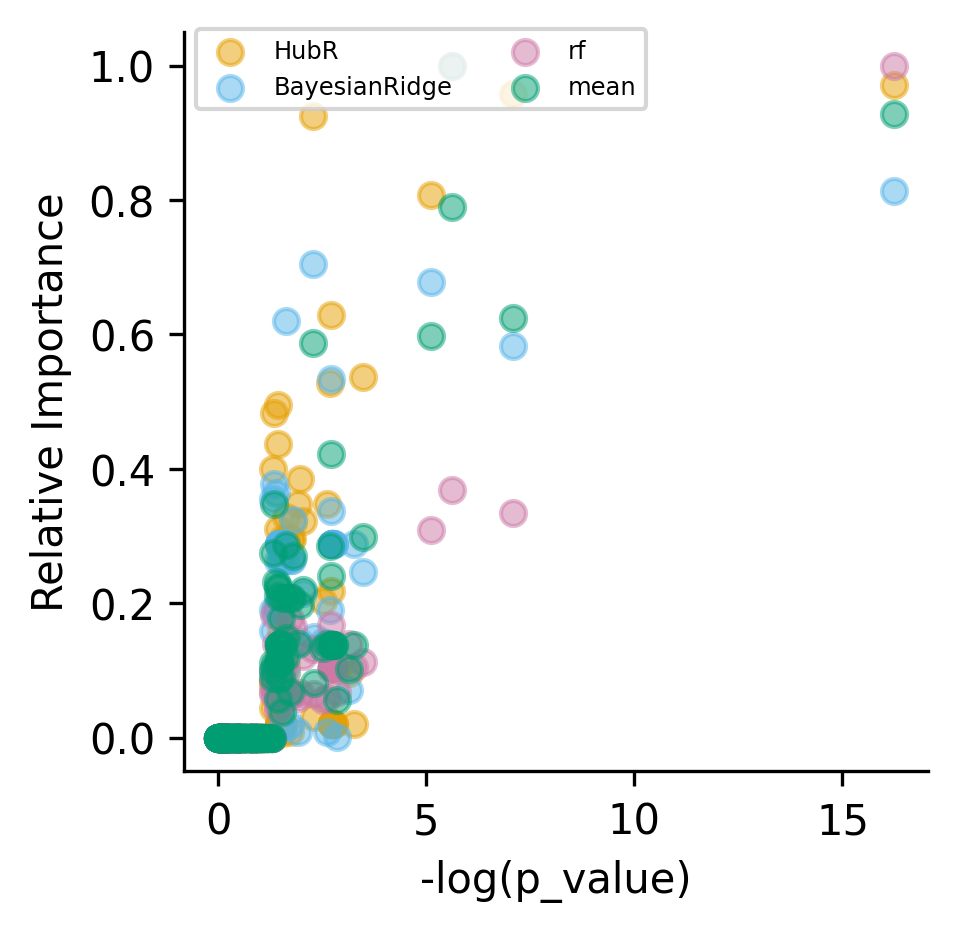

In [18]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [19]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: user 56.9 ms, sys: 6.72 ms, total: 63.6 ms
Wall time: 61.5 ms


mean Done


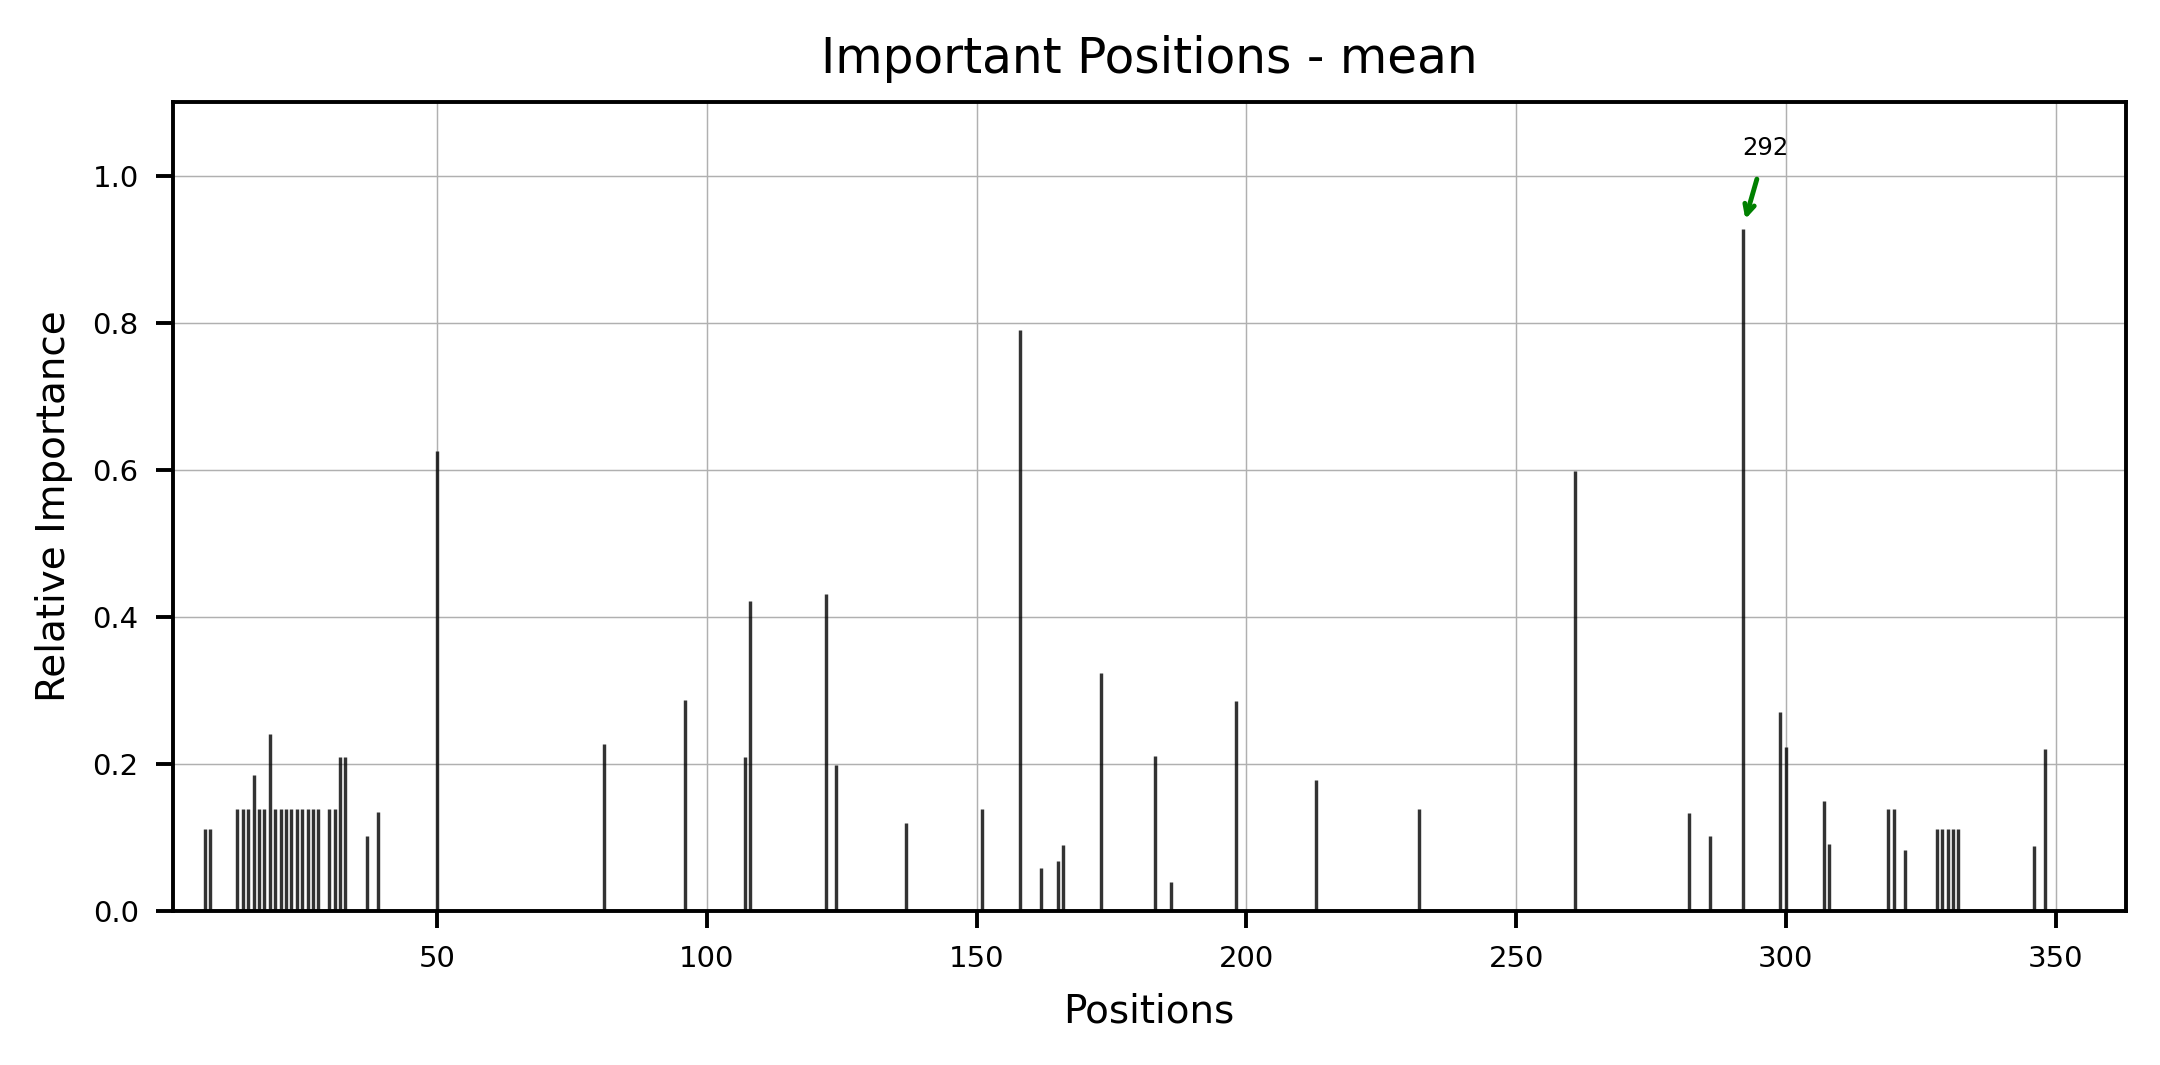

In [20]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [21]:
tr = prep_pipeline[:4].fit_transform(tr)

HubR Done
HubR  Done
BayesianRidge Done
BayesianRidge  Done
rf Done
rf  Done


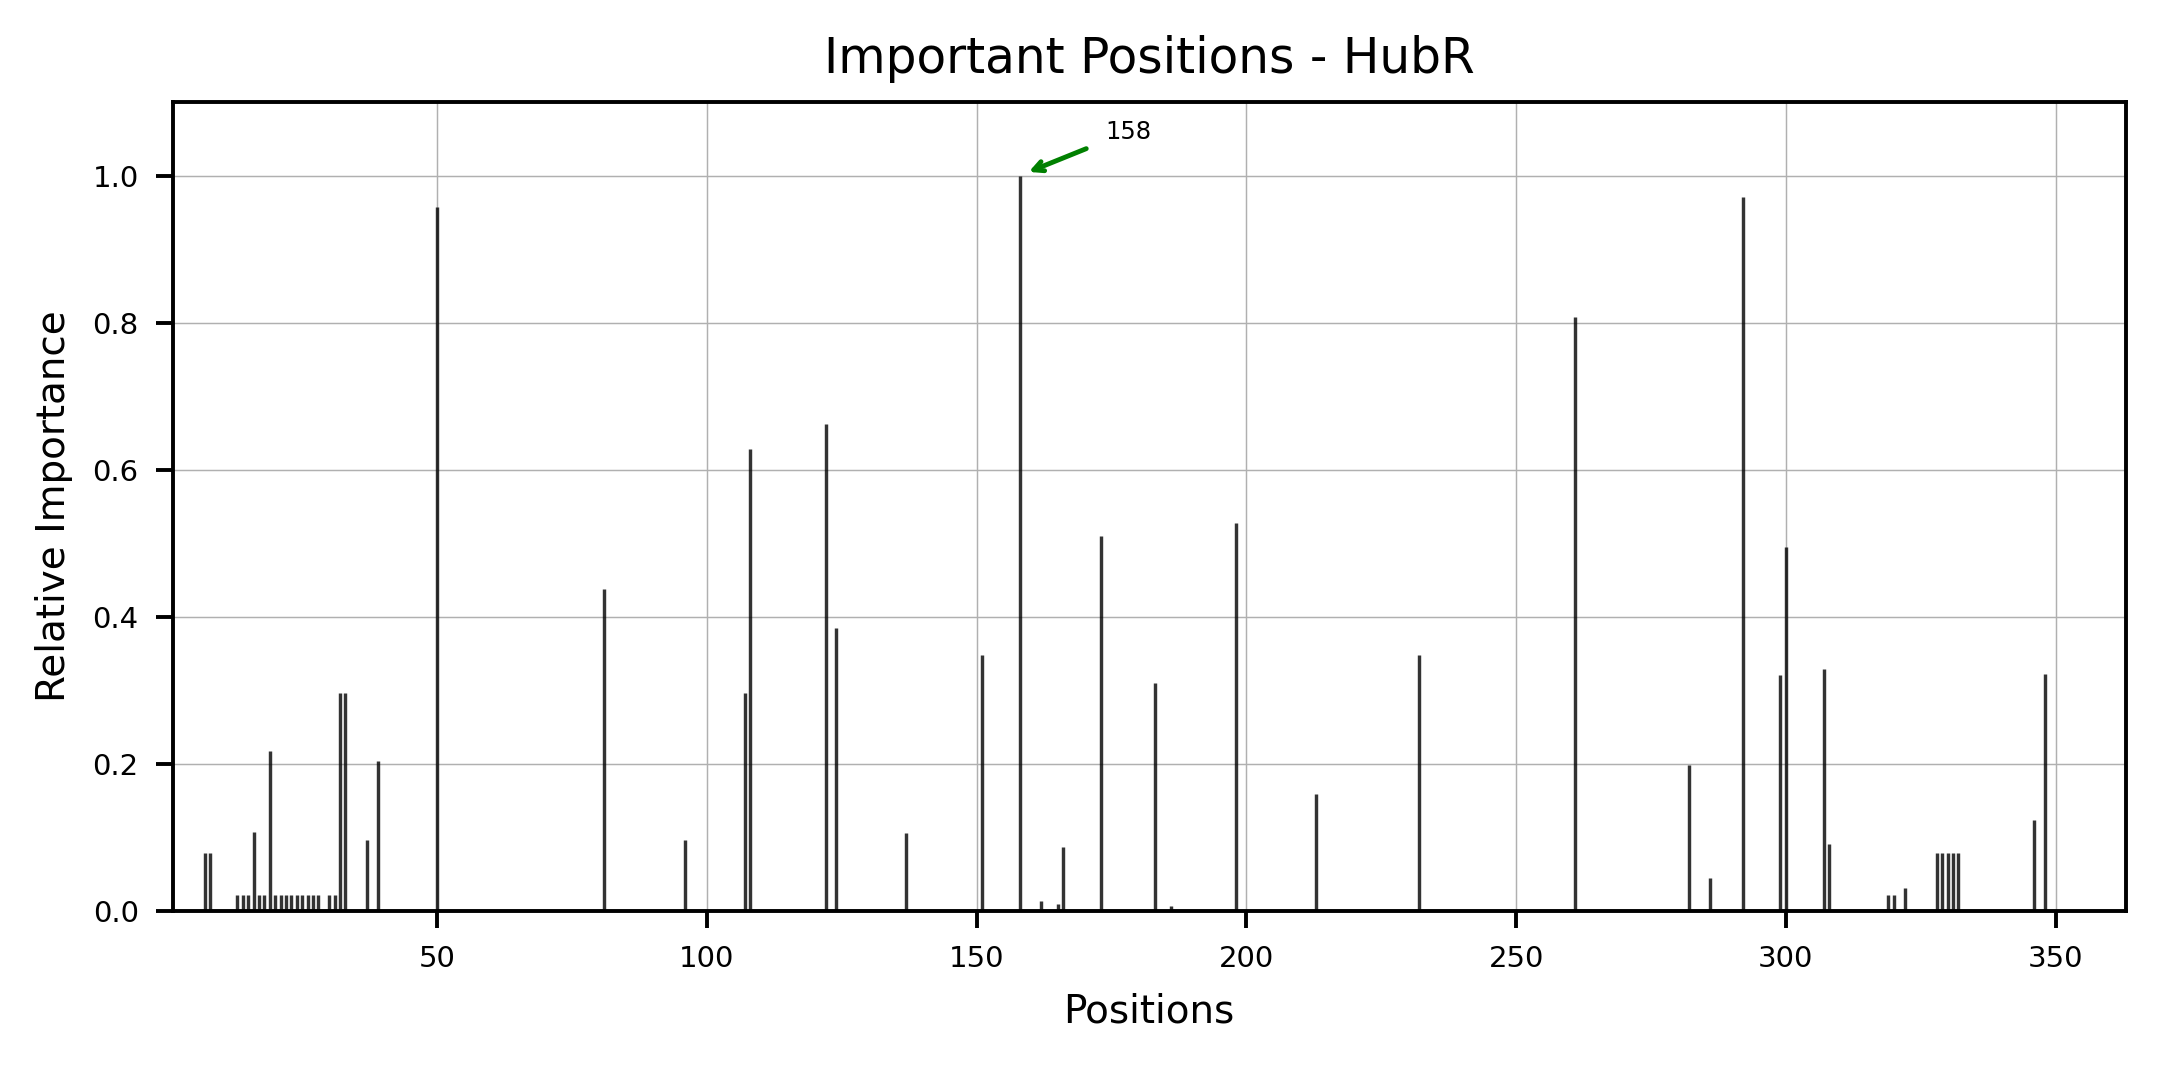

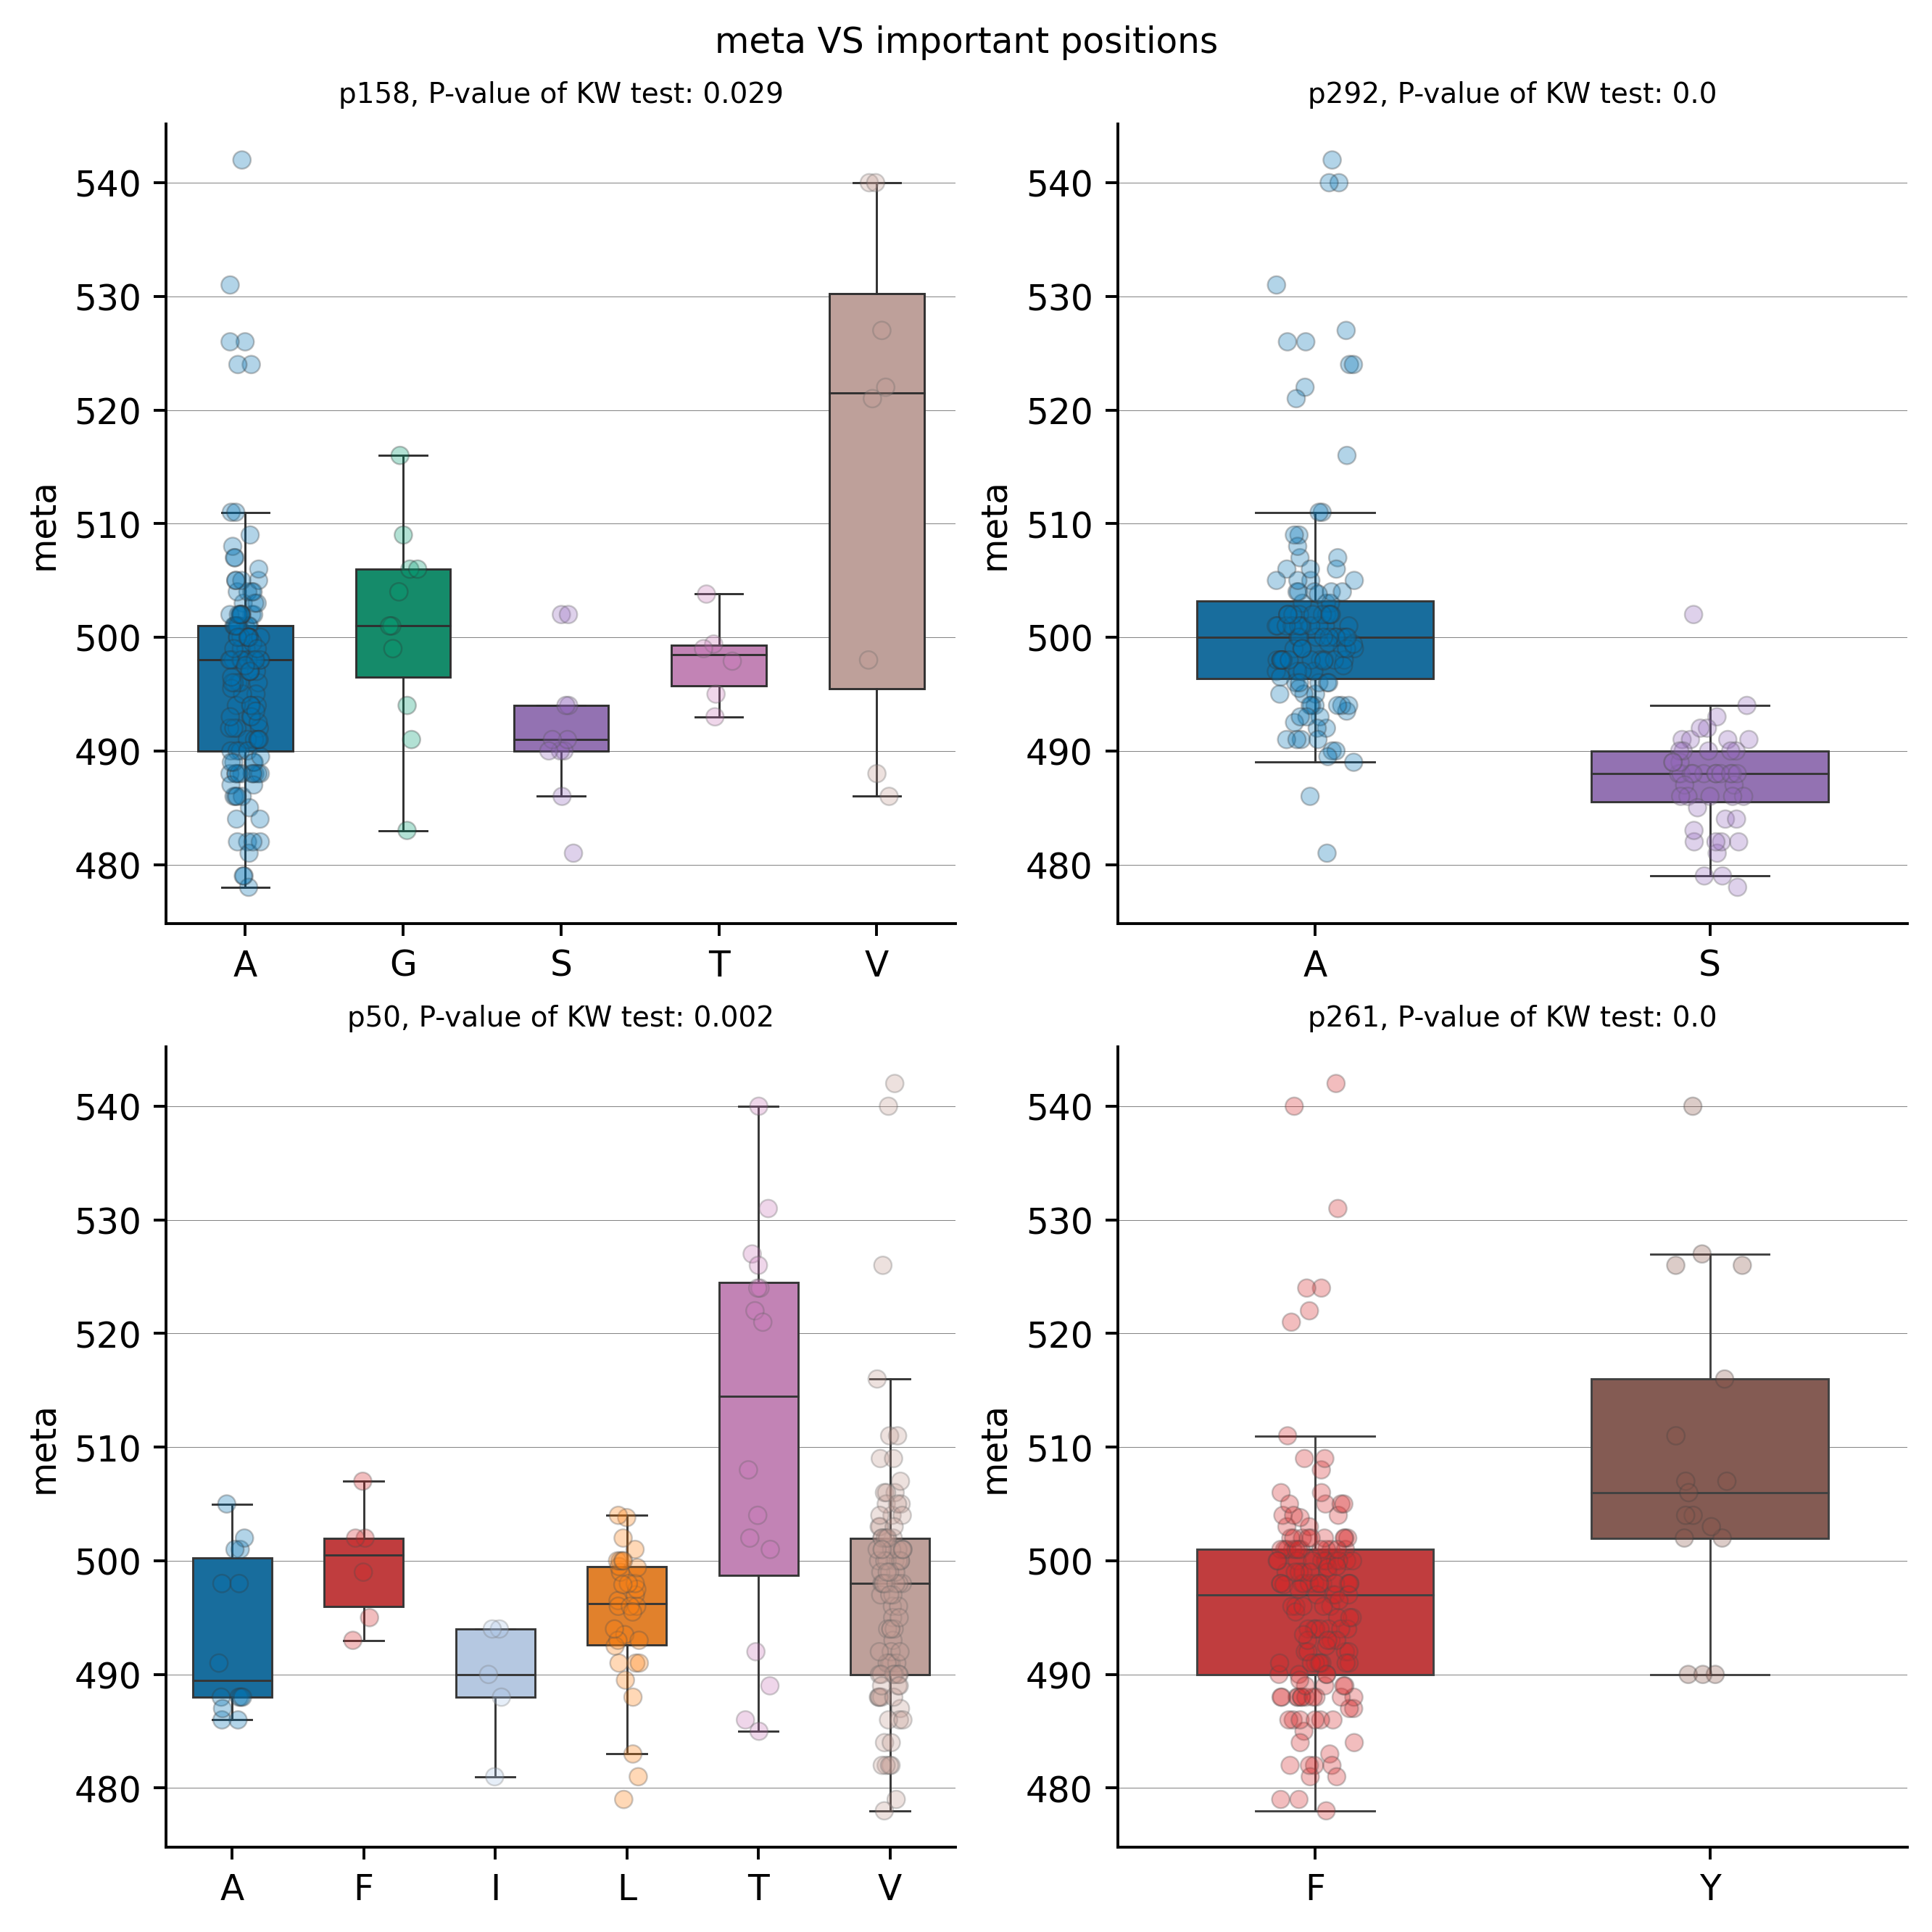

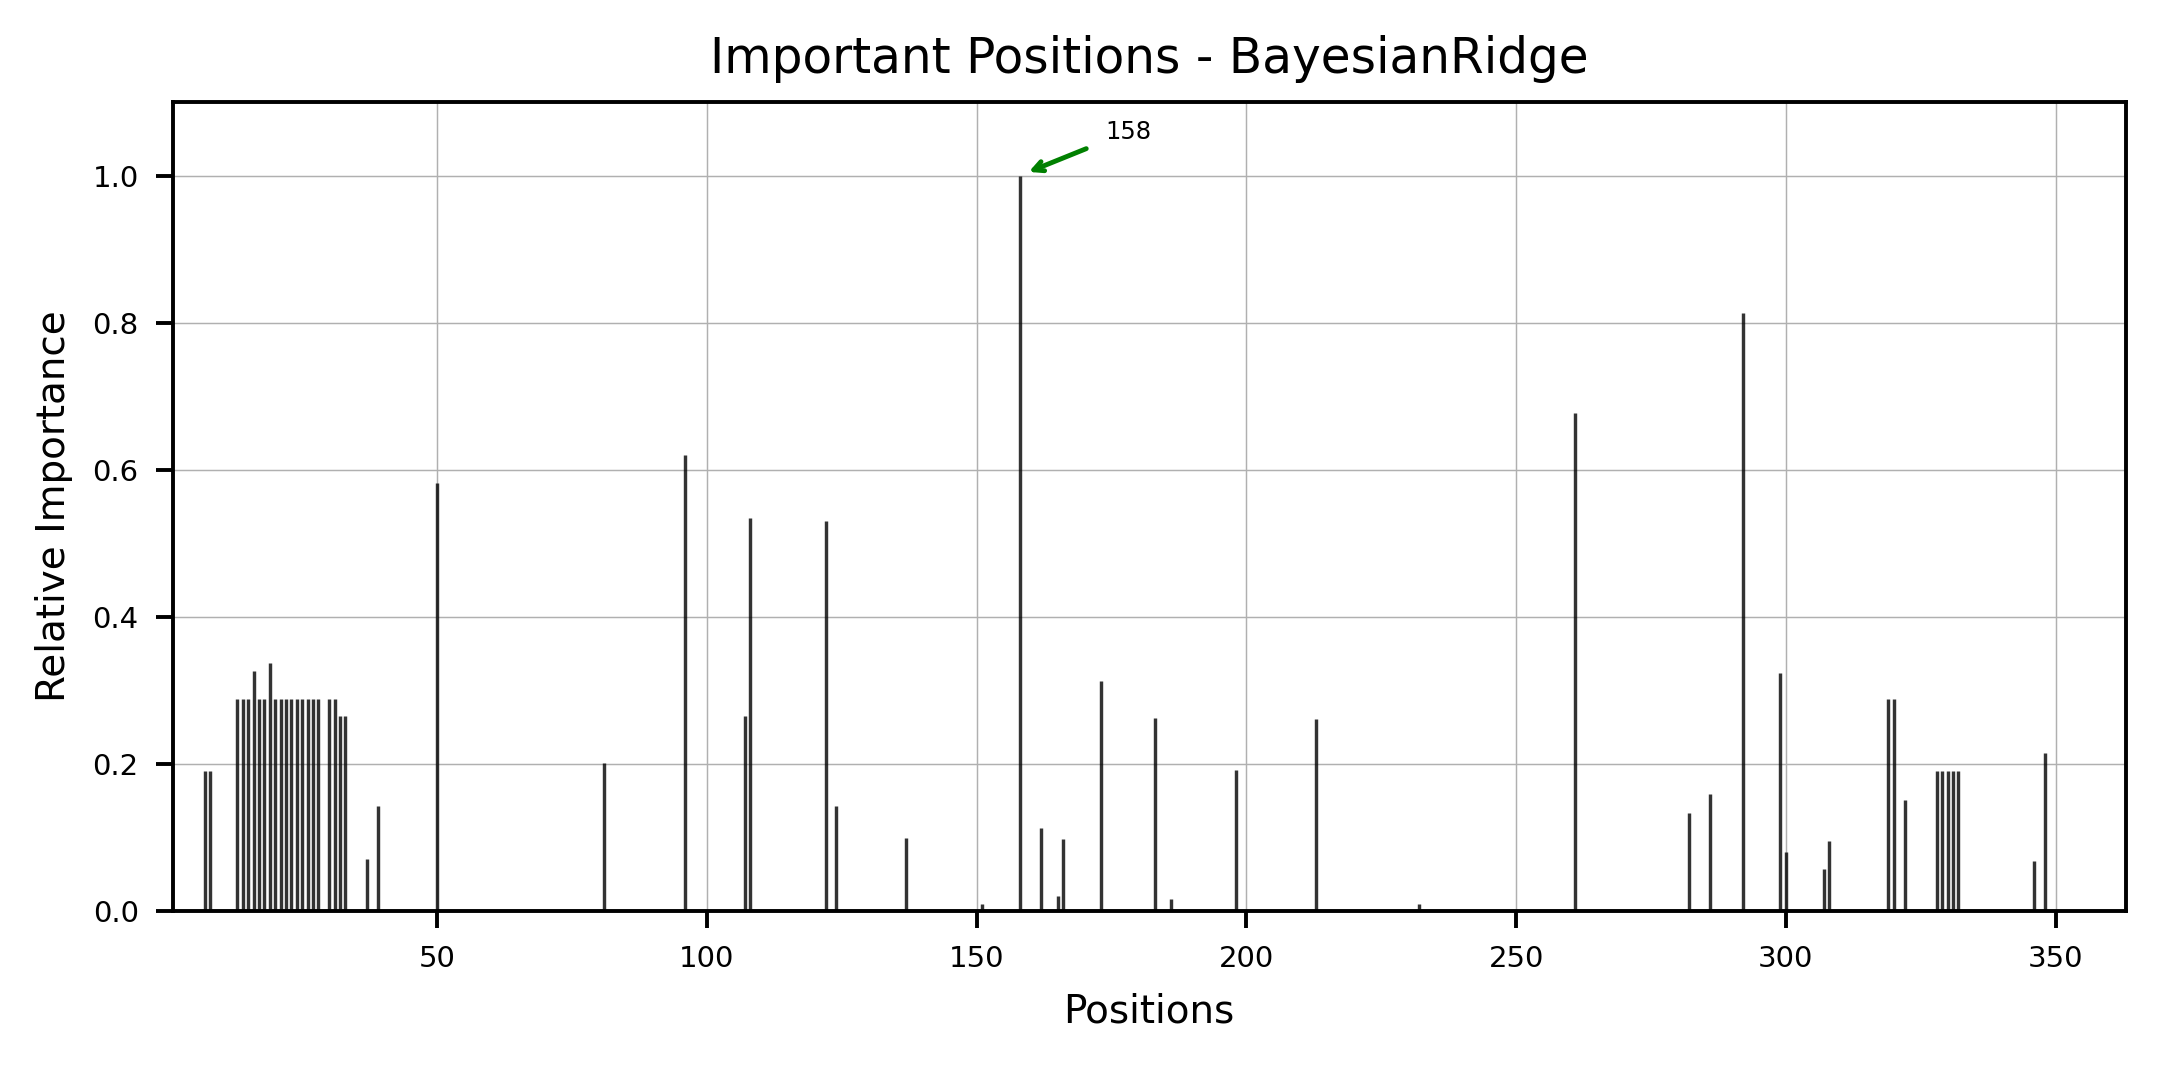

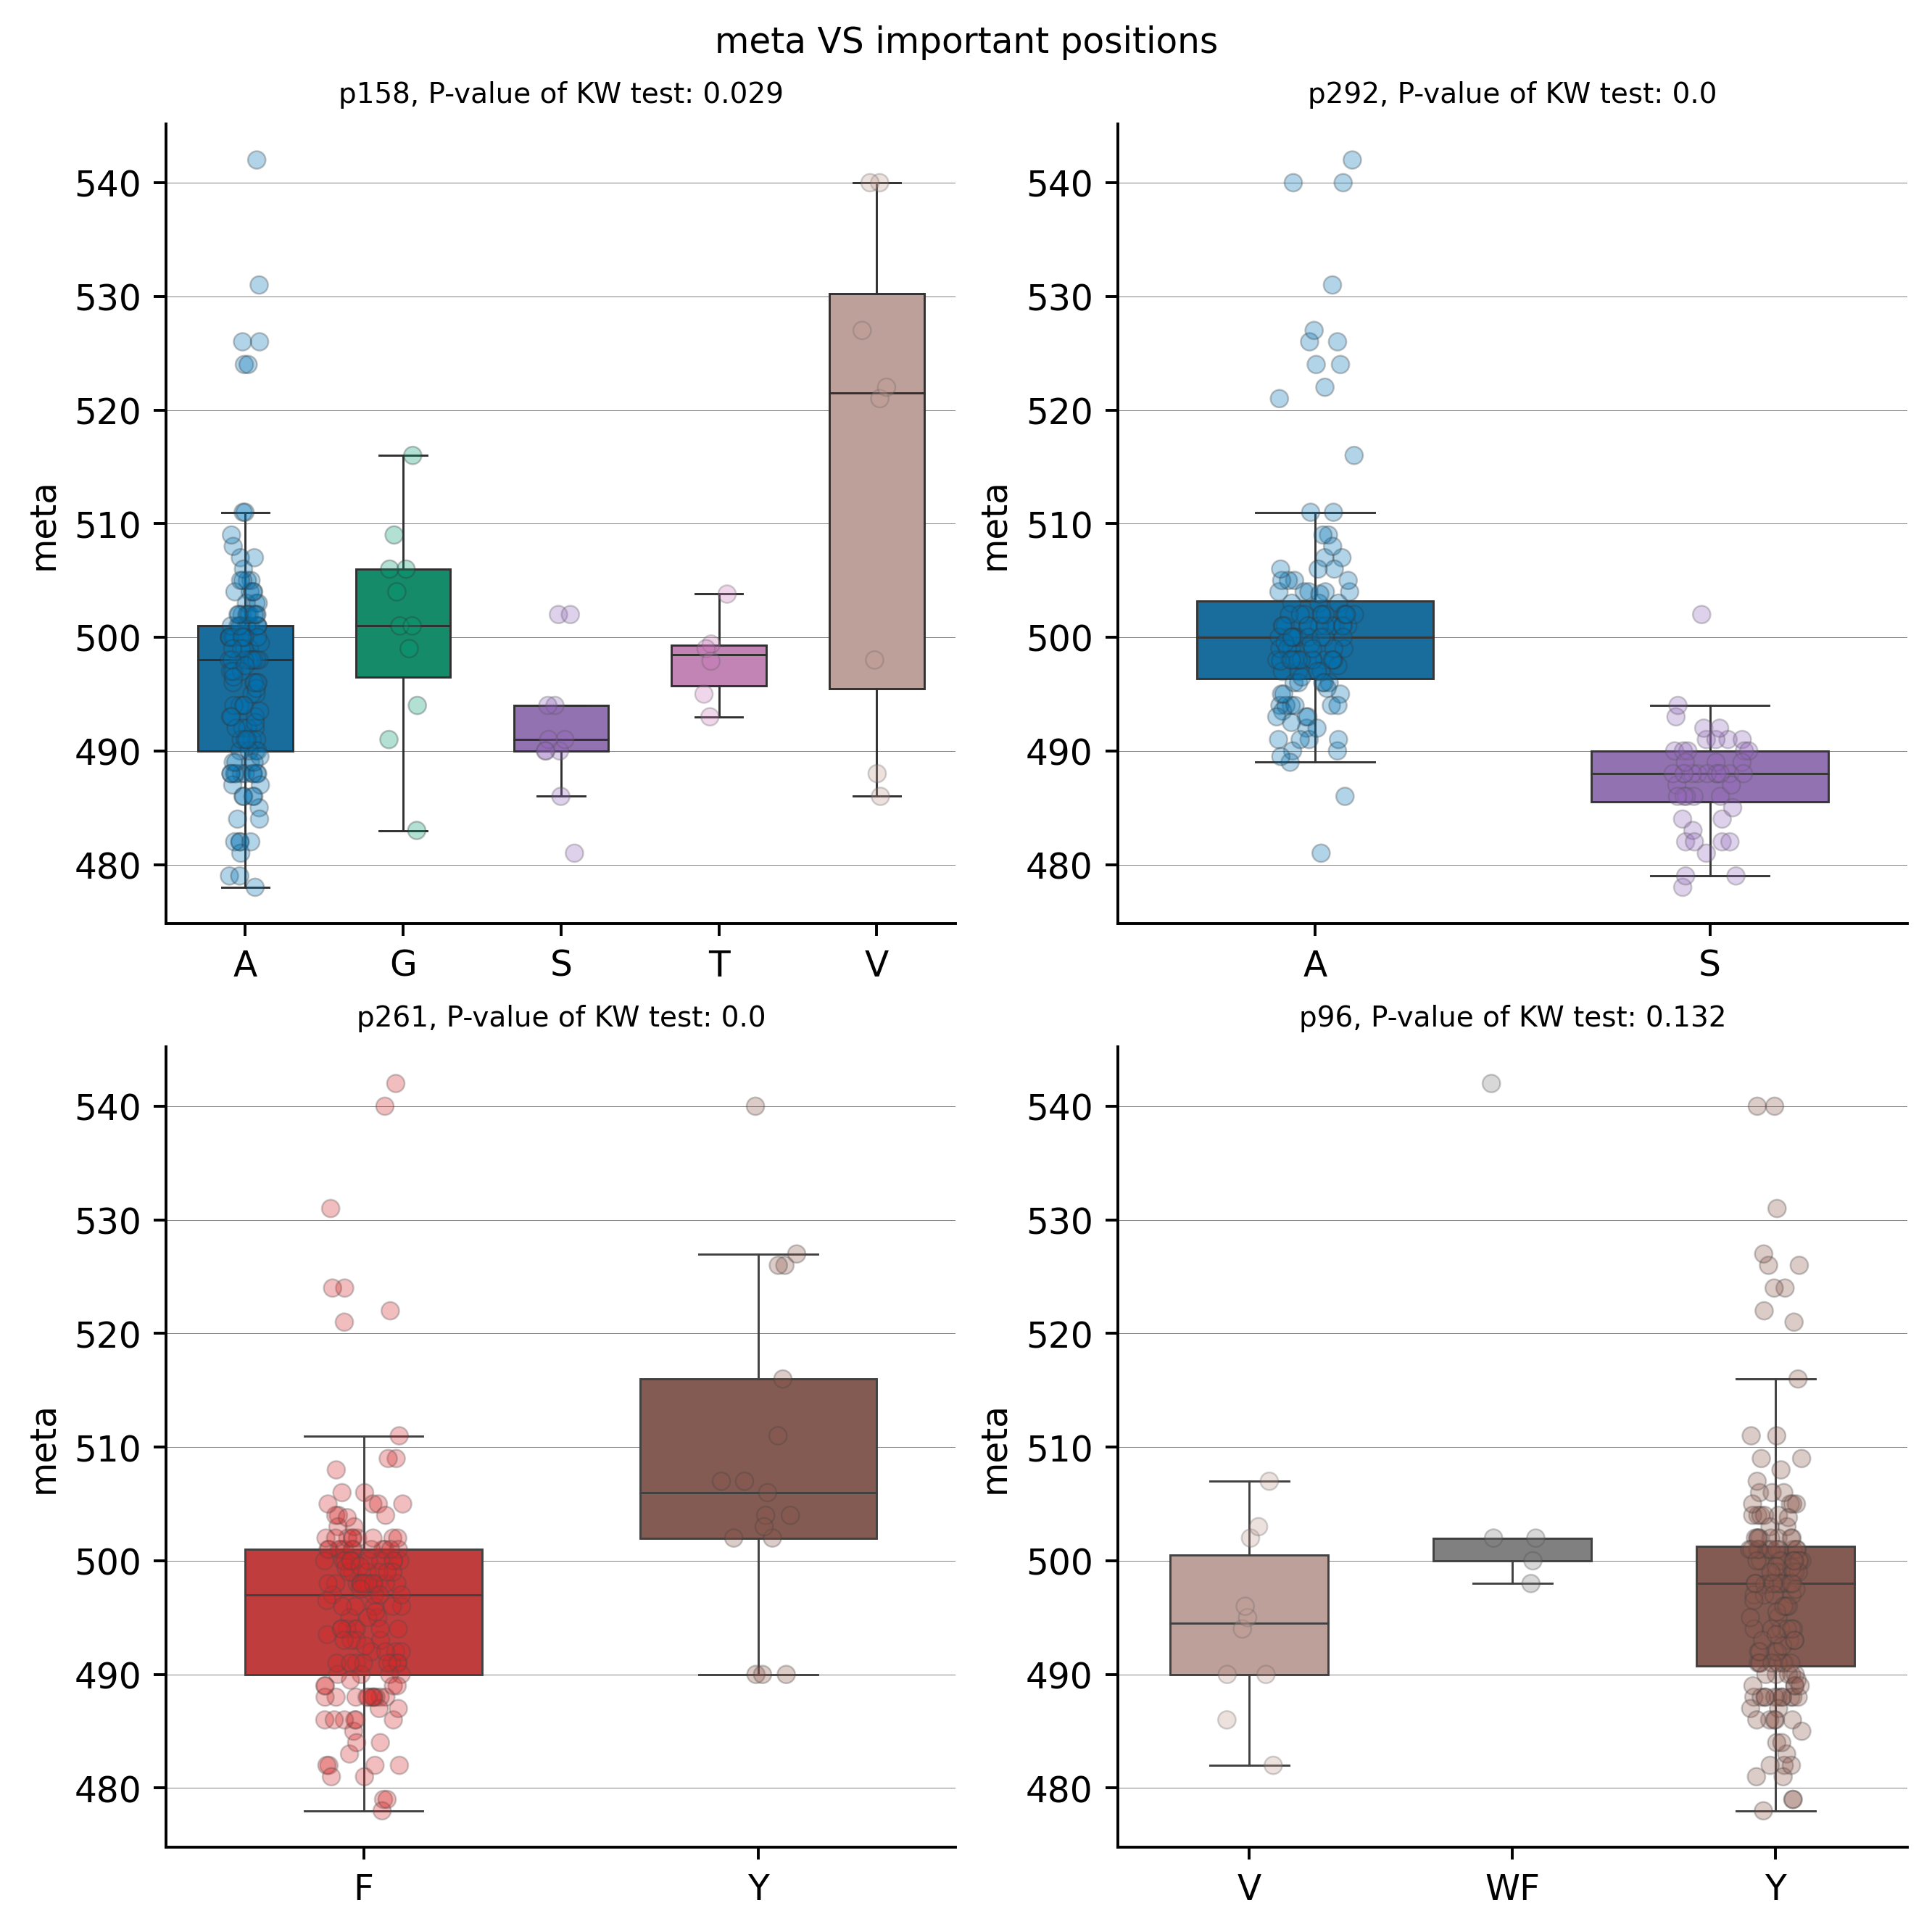

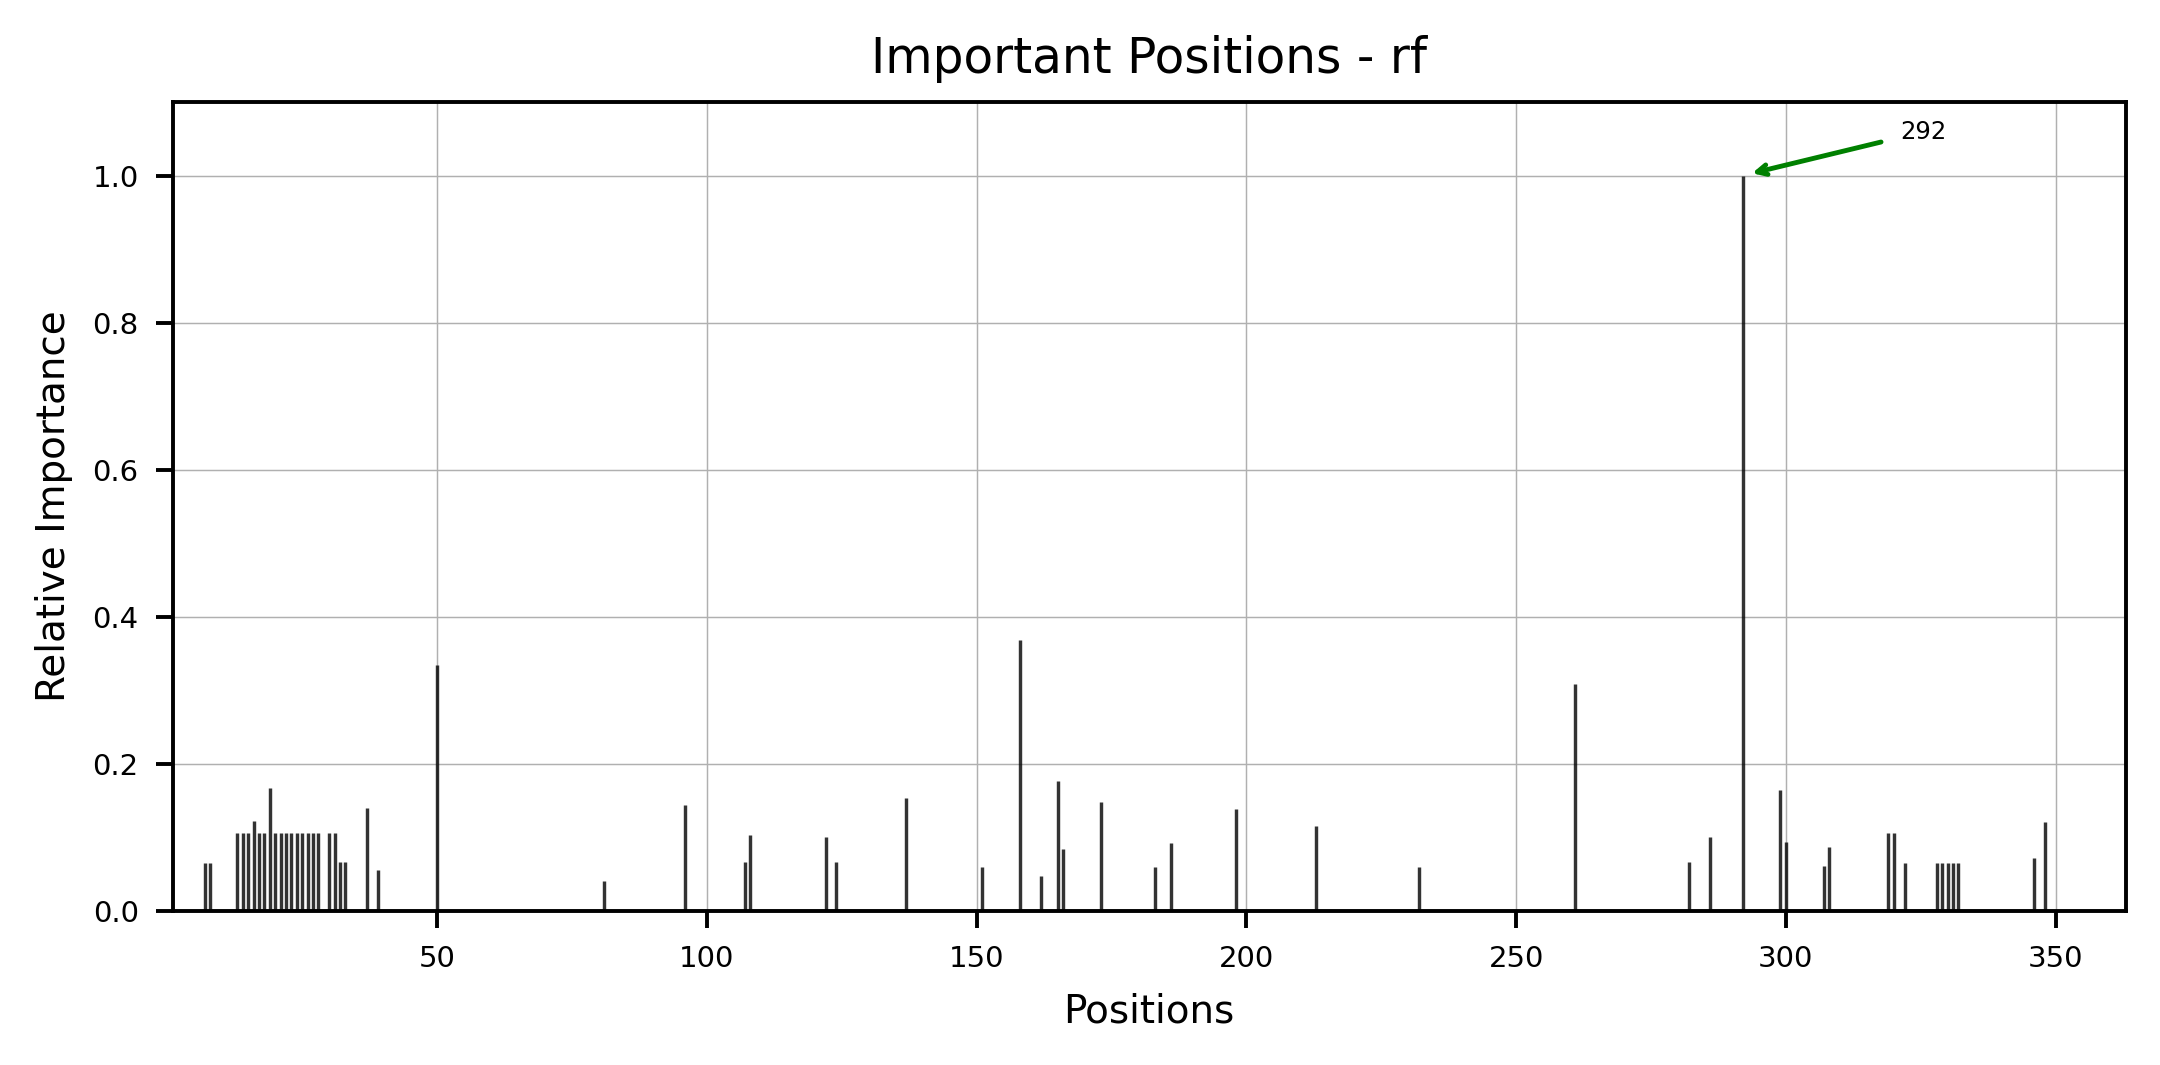

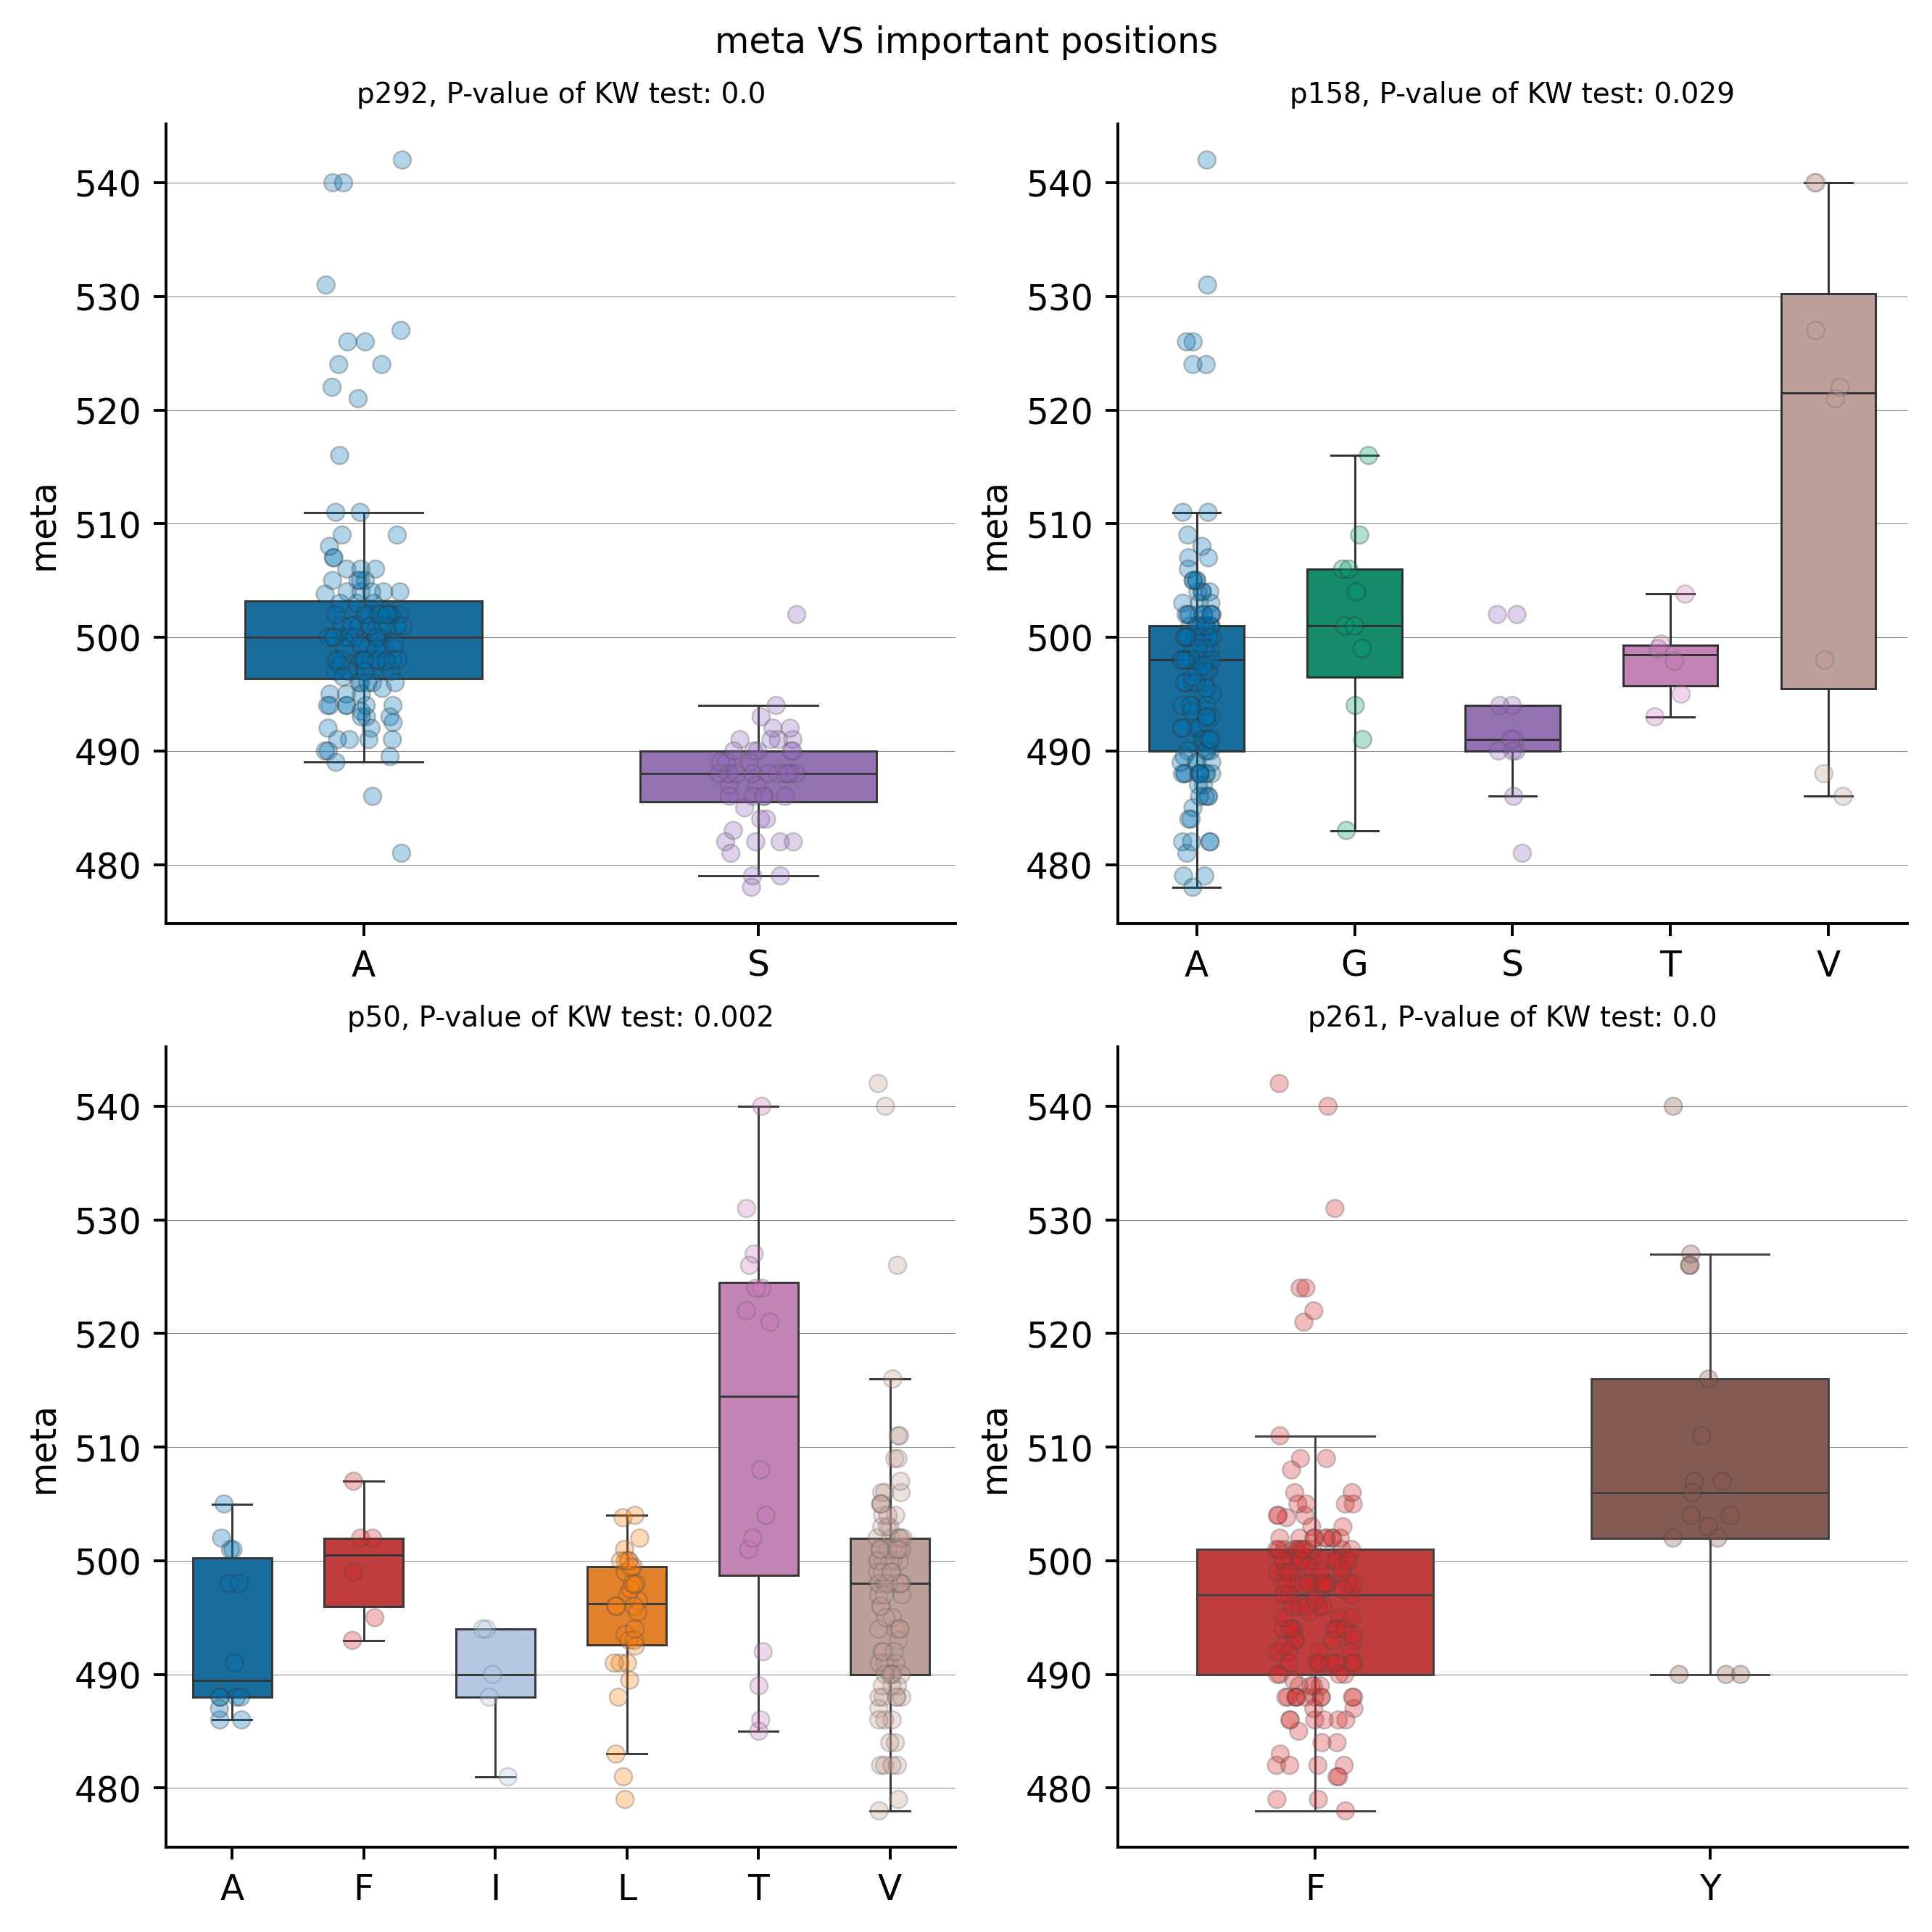

In [22]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

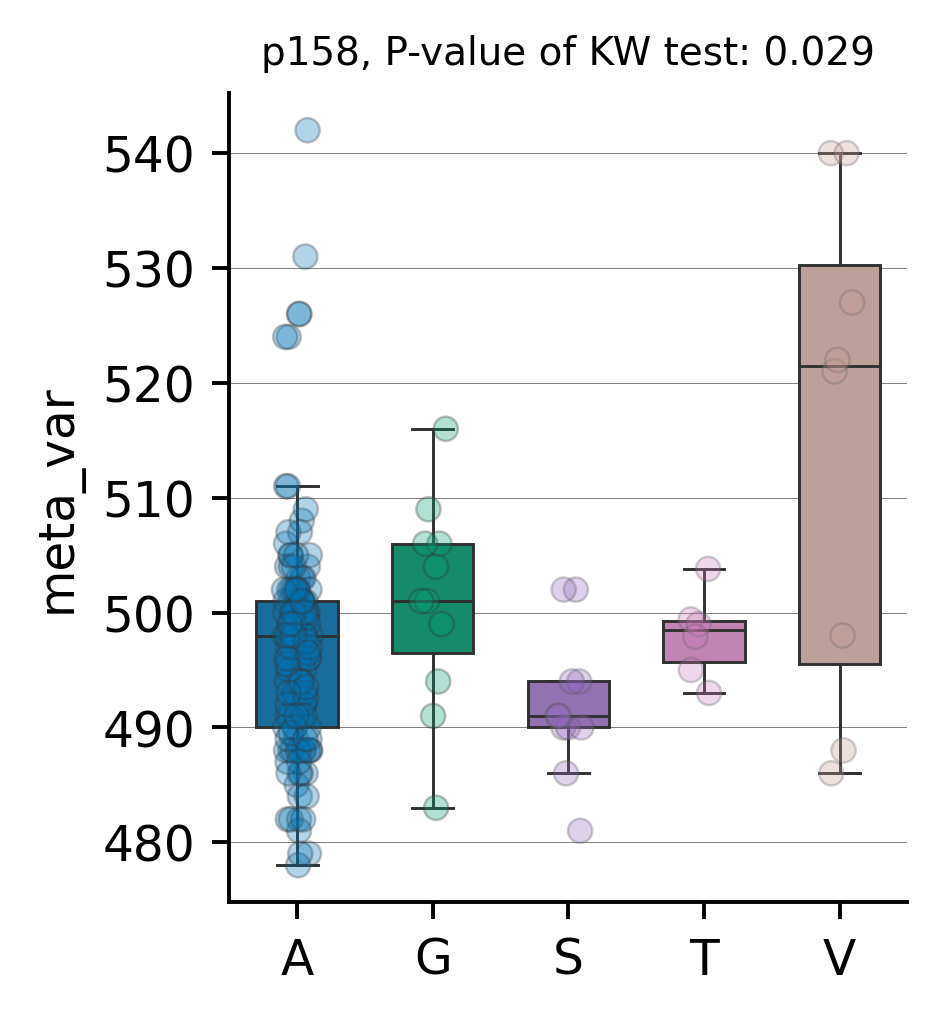

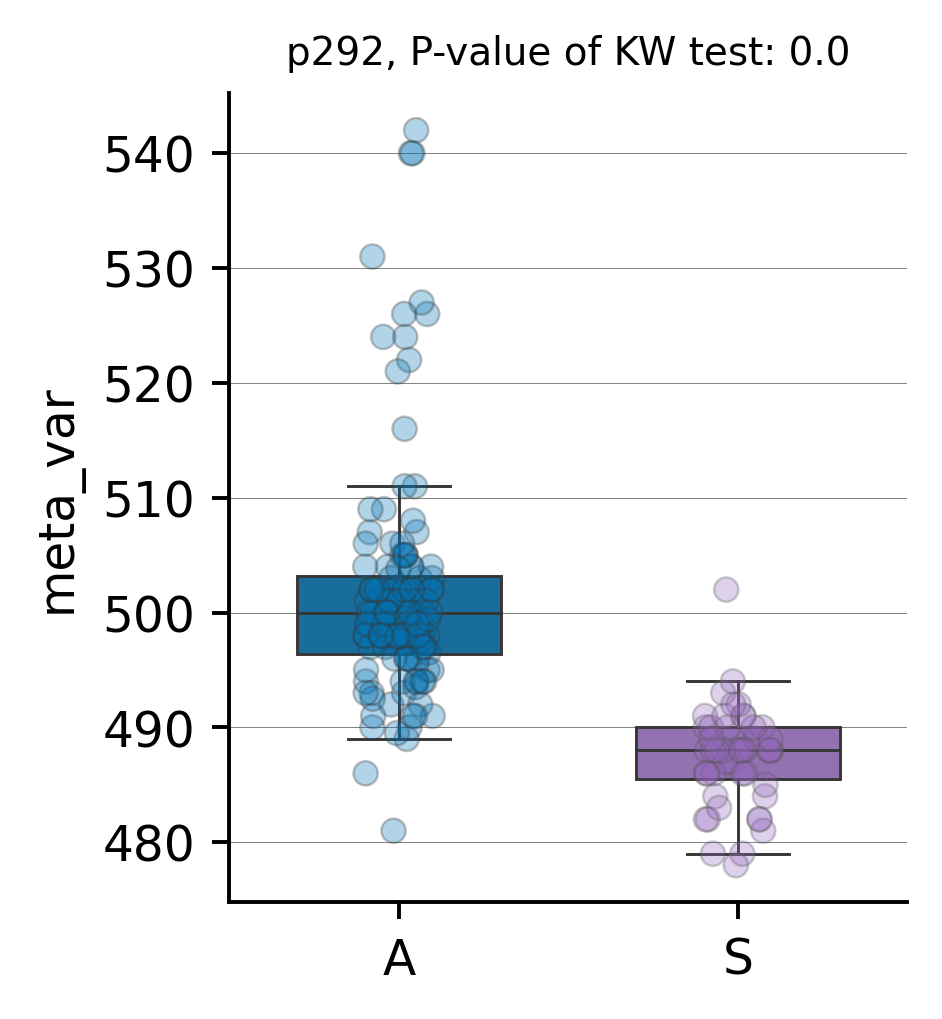

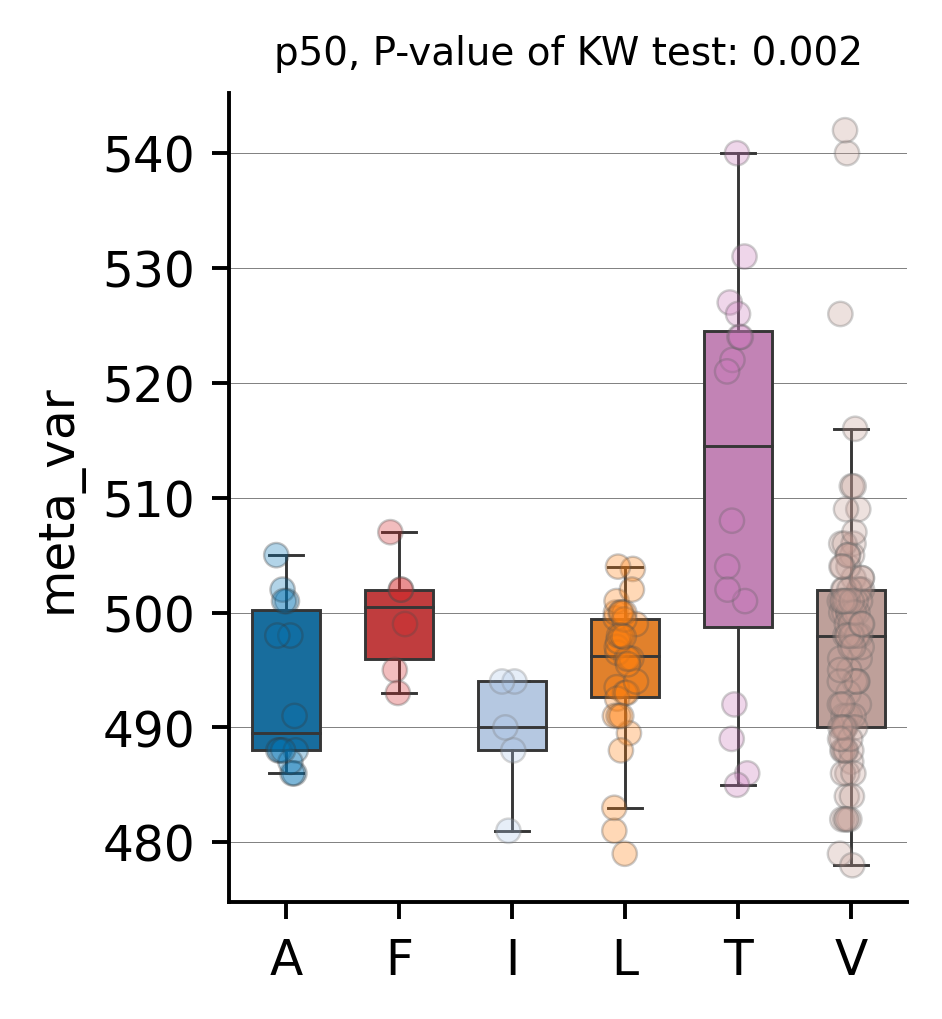

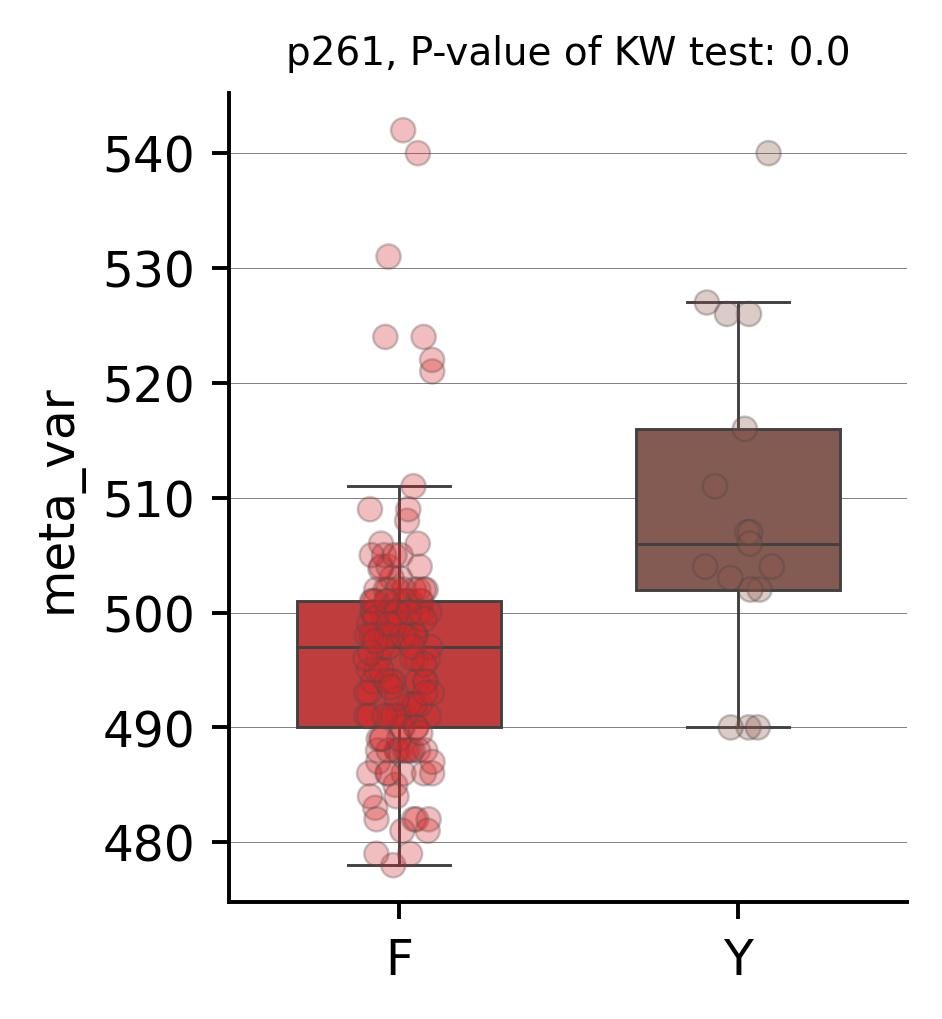

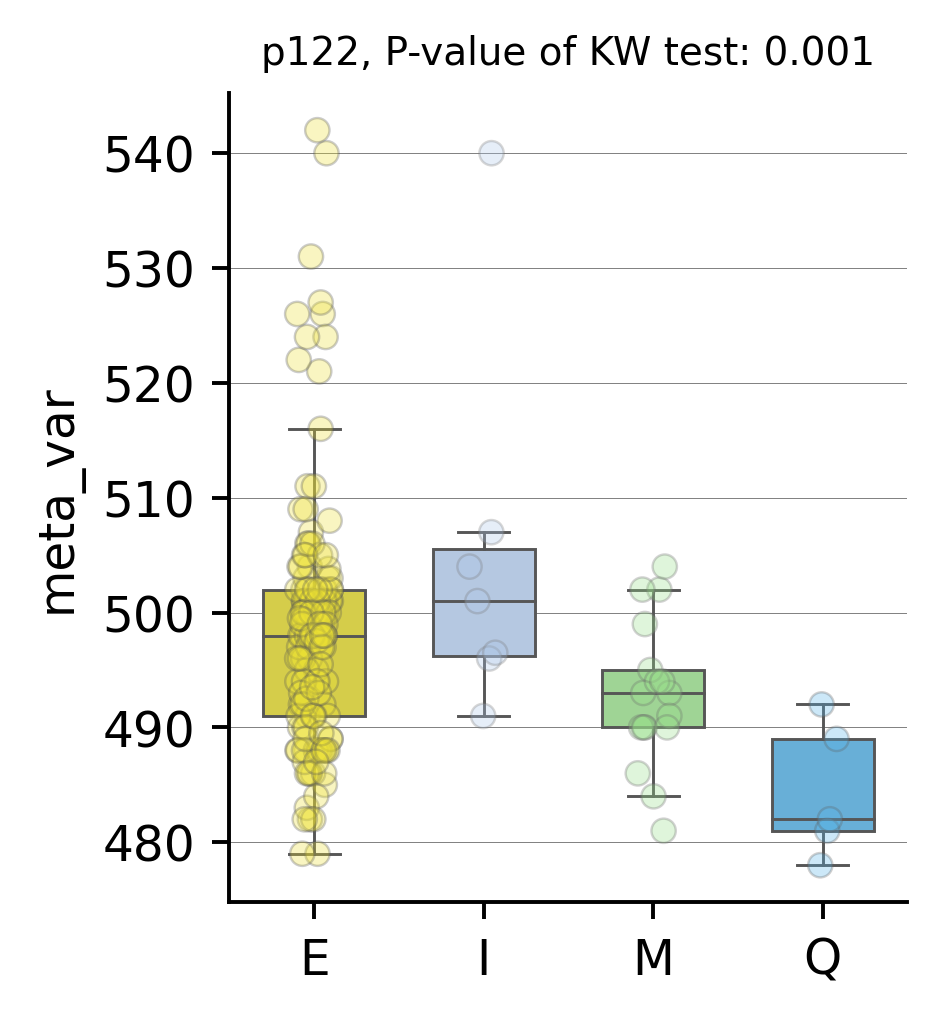

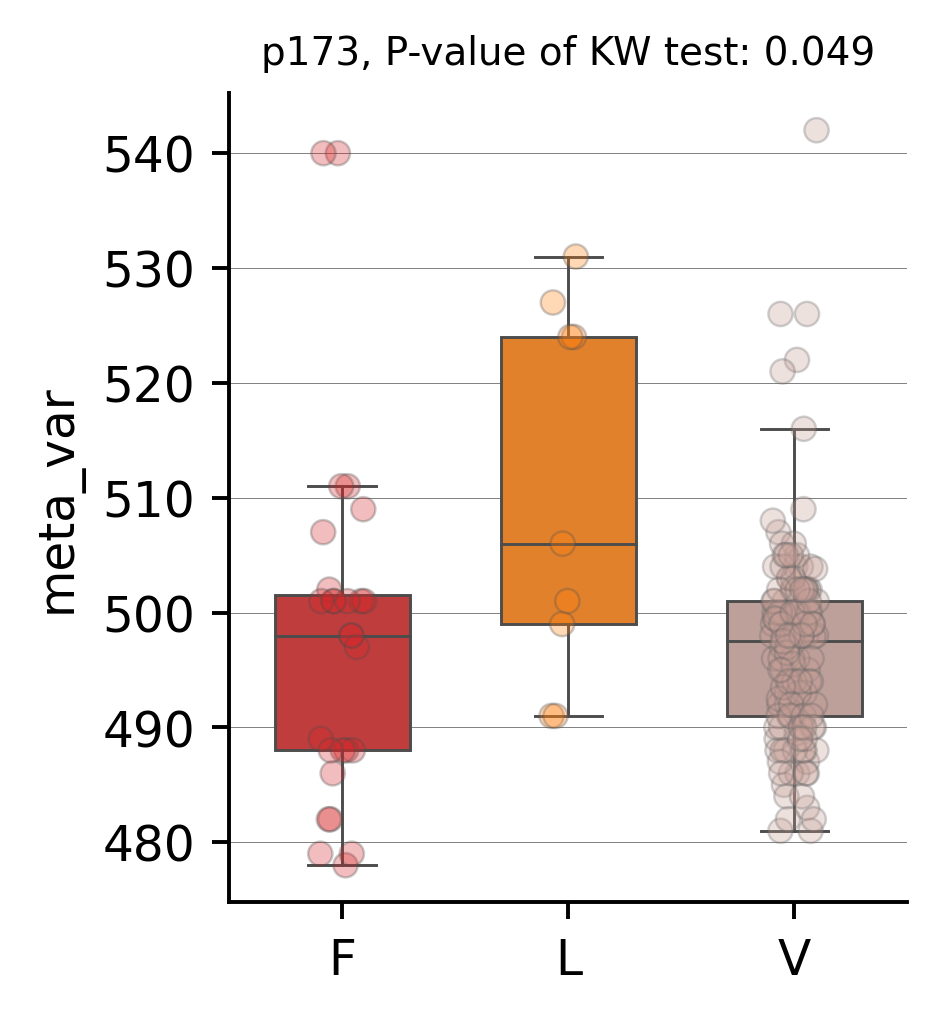

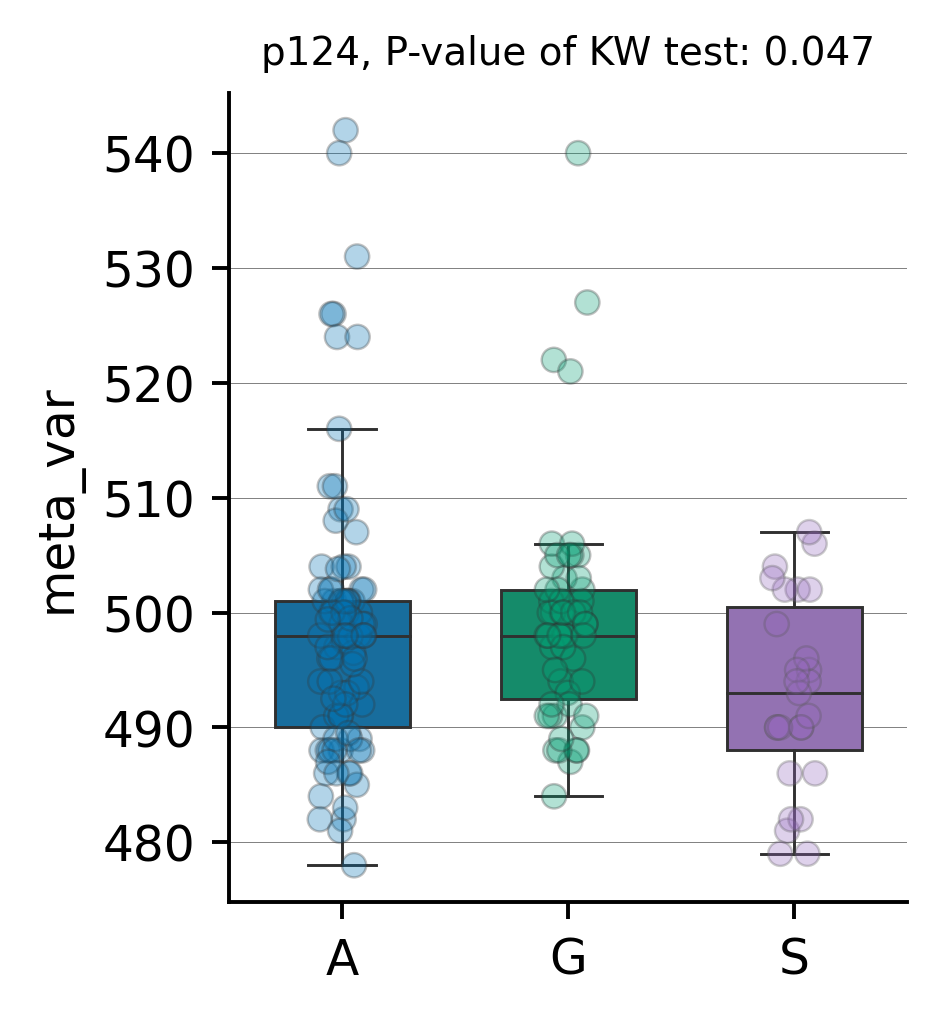

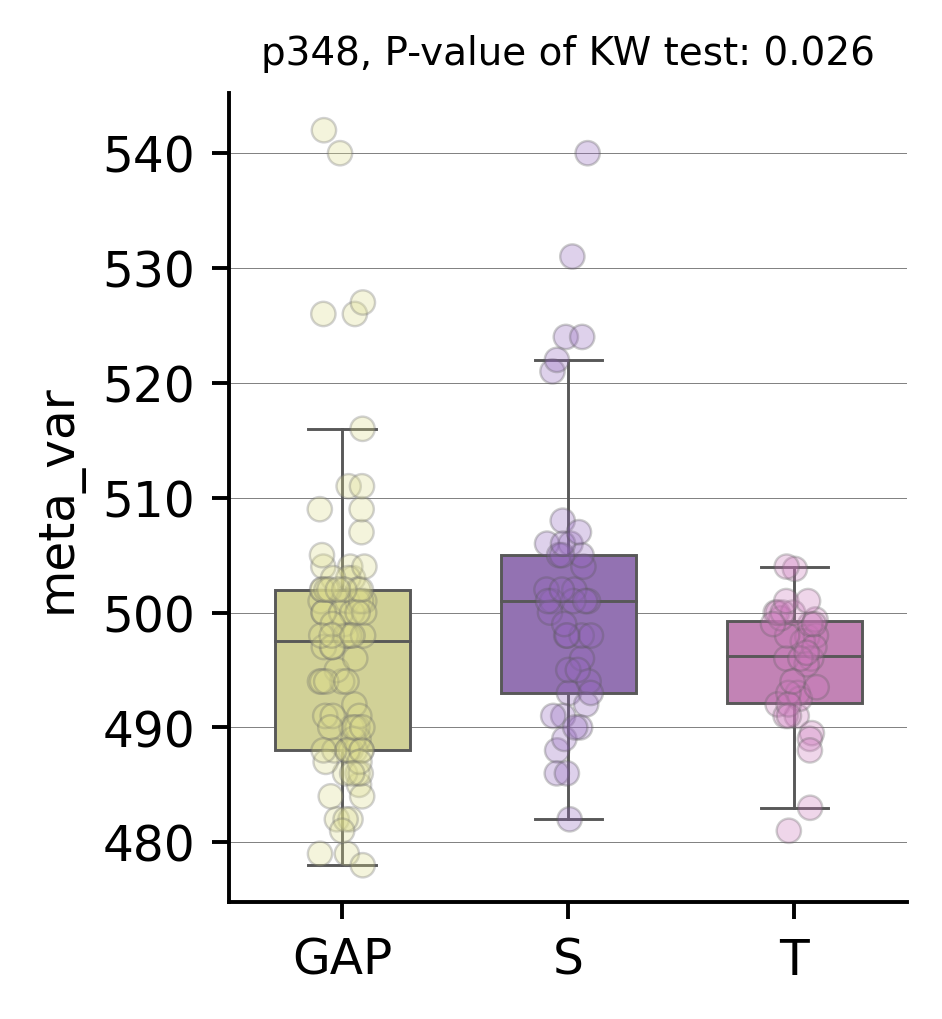

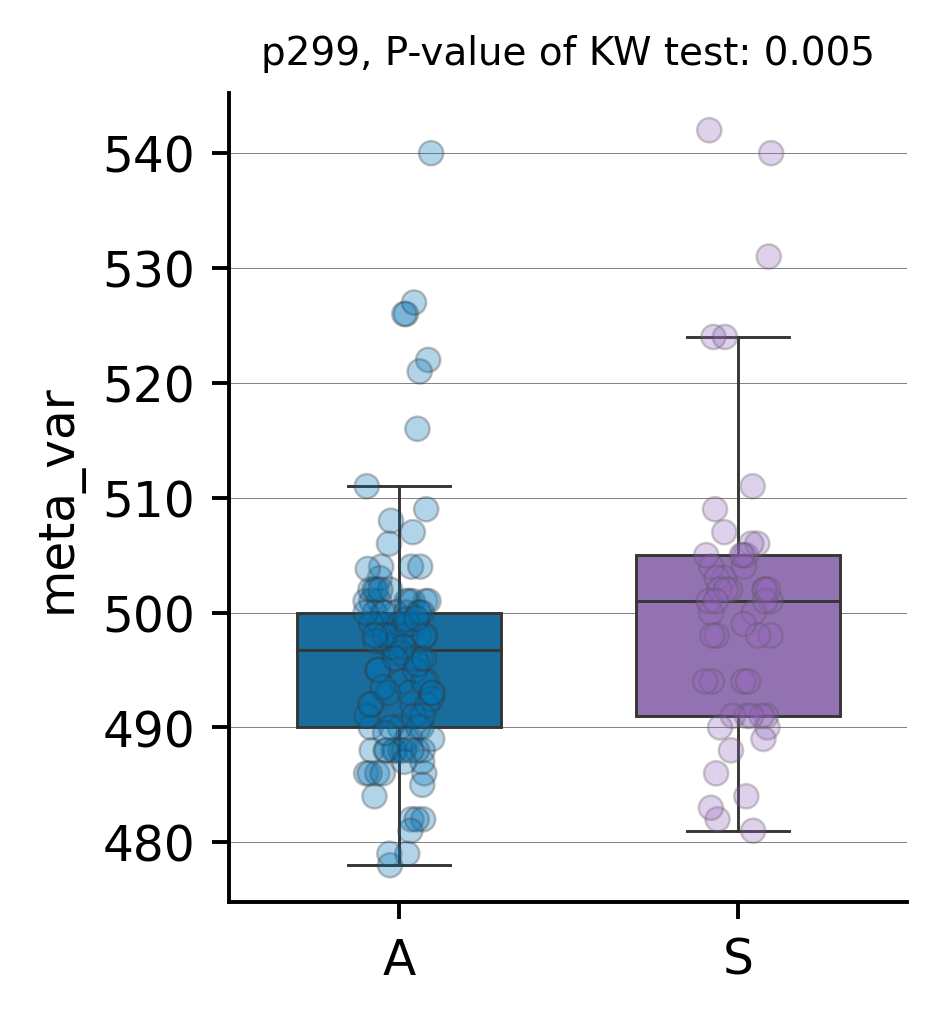

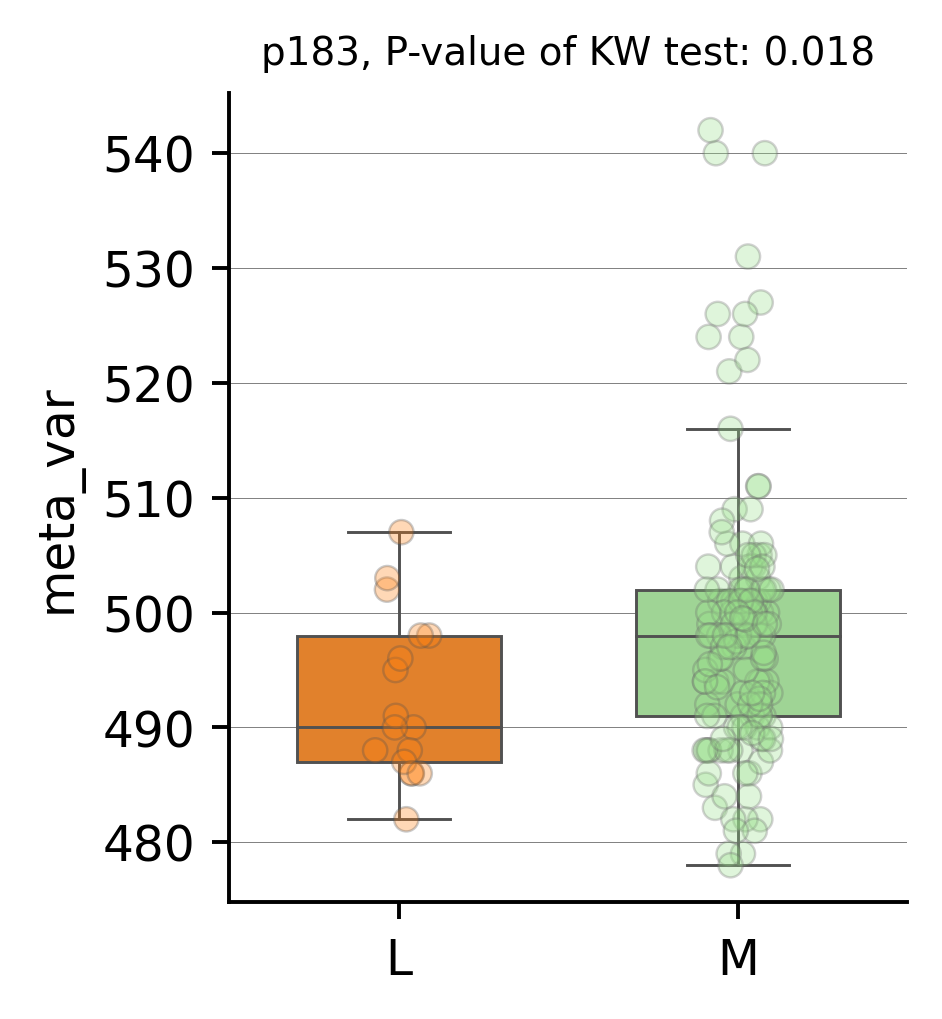

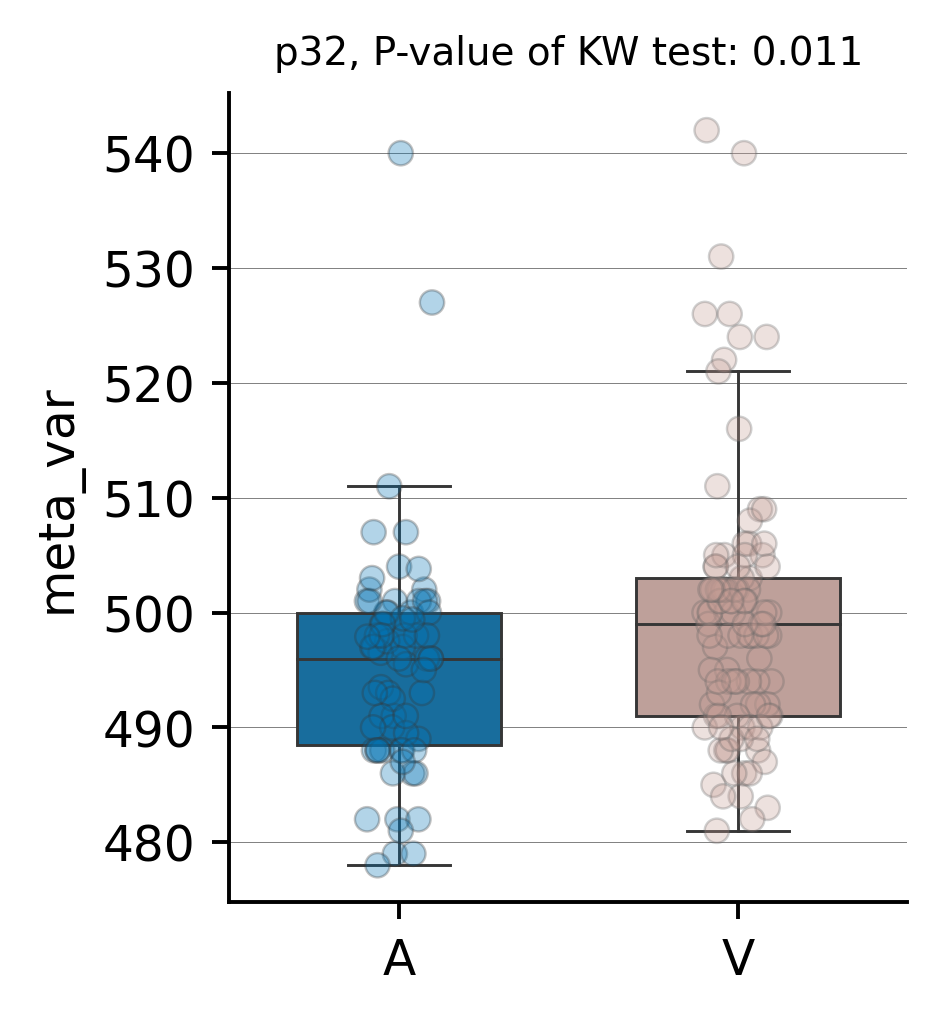

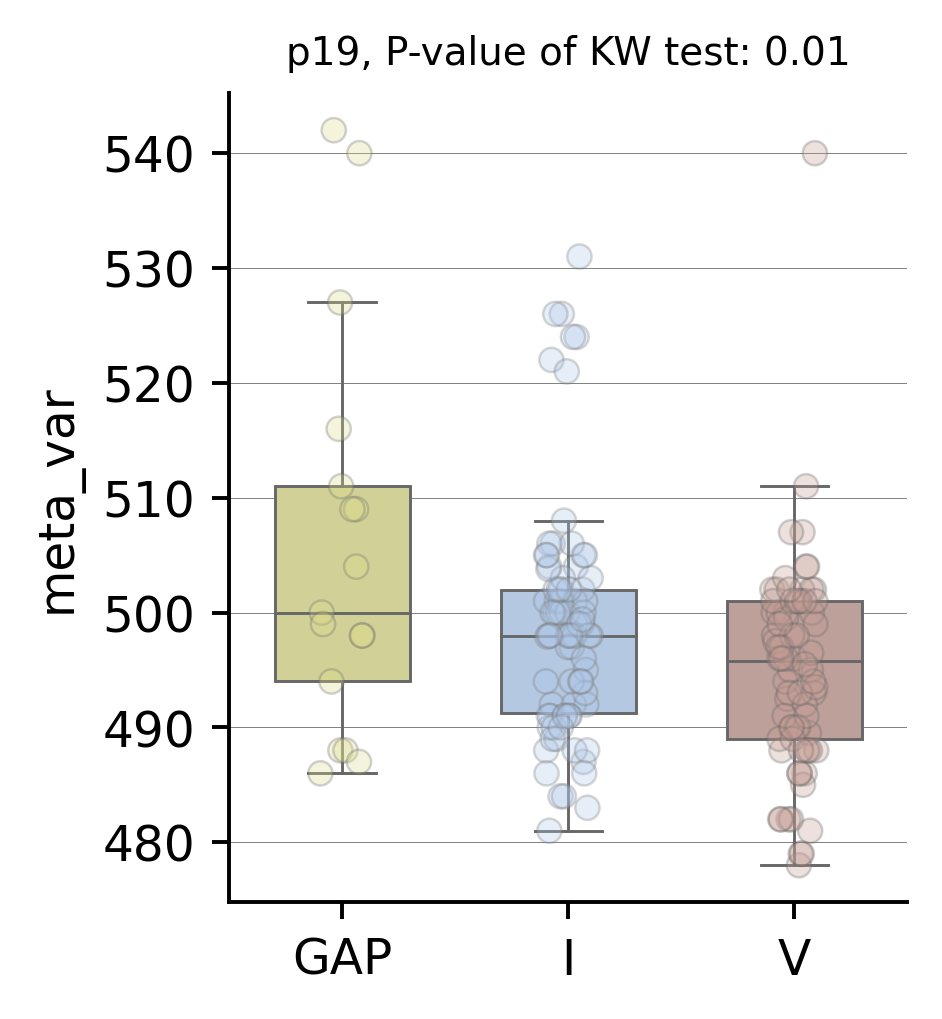

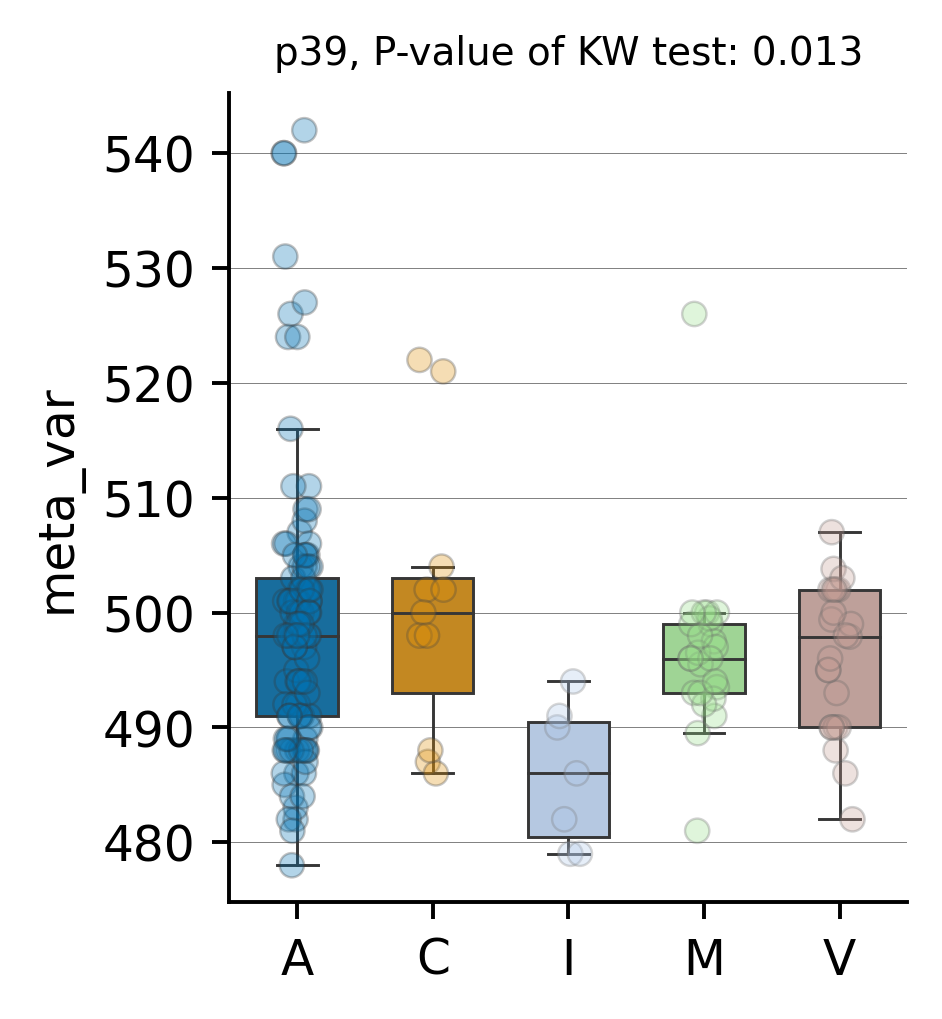

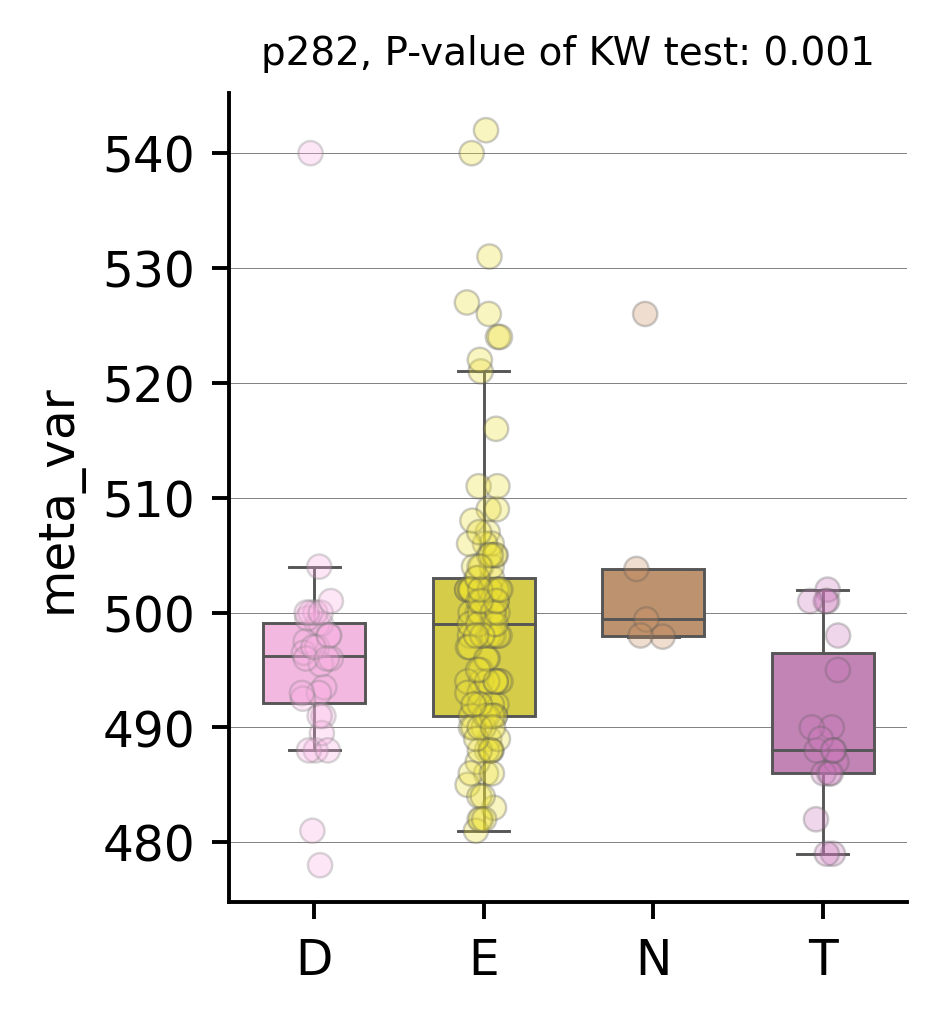

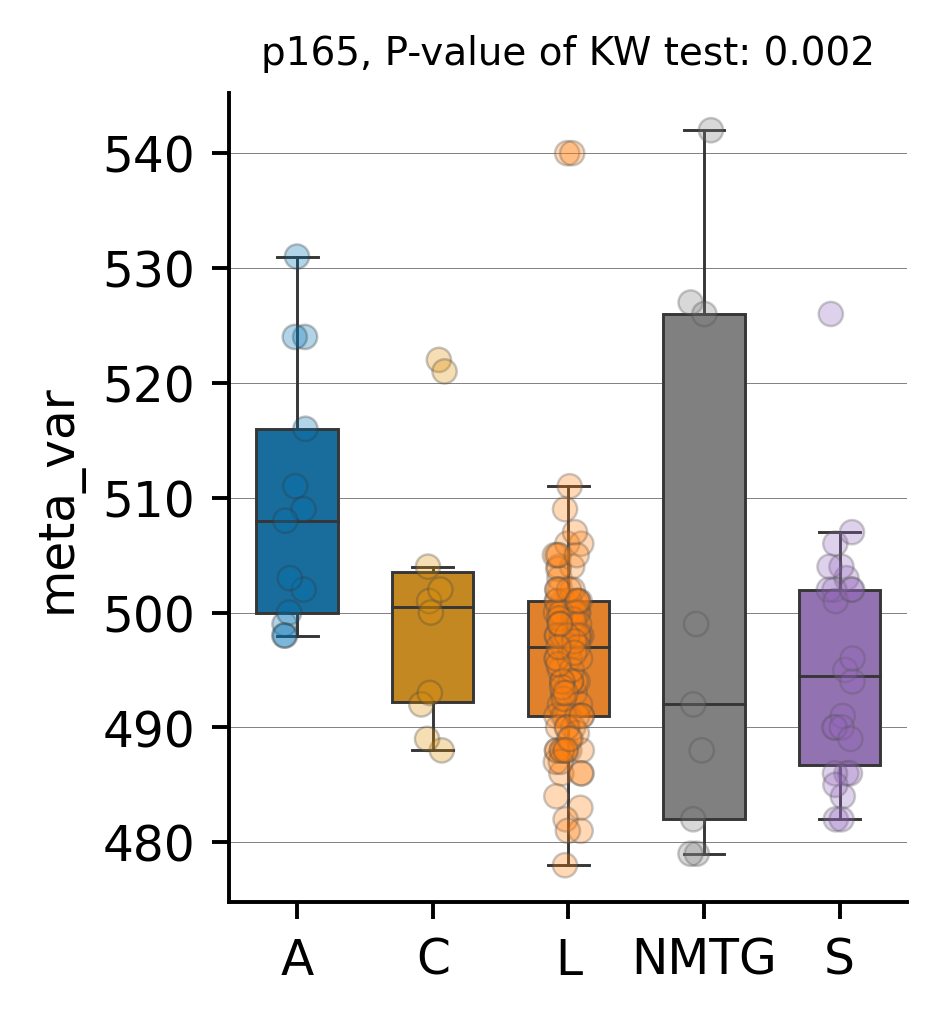

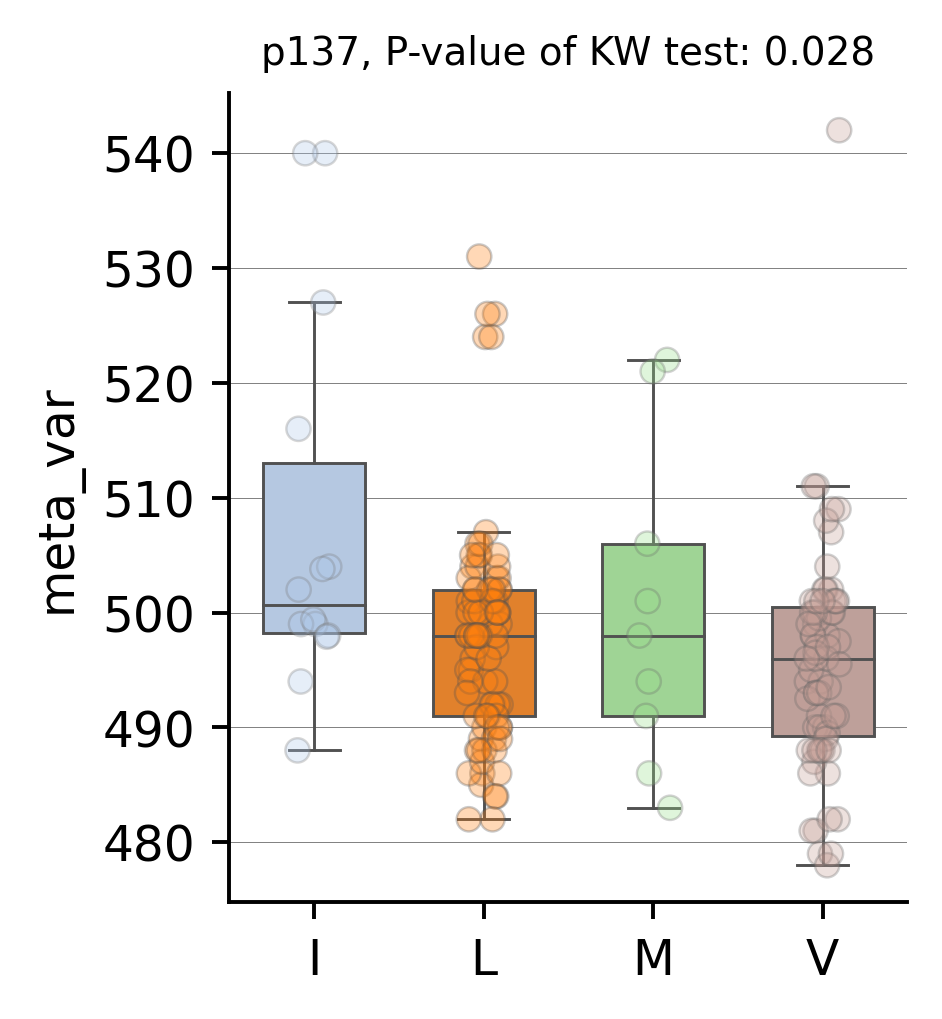

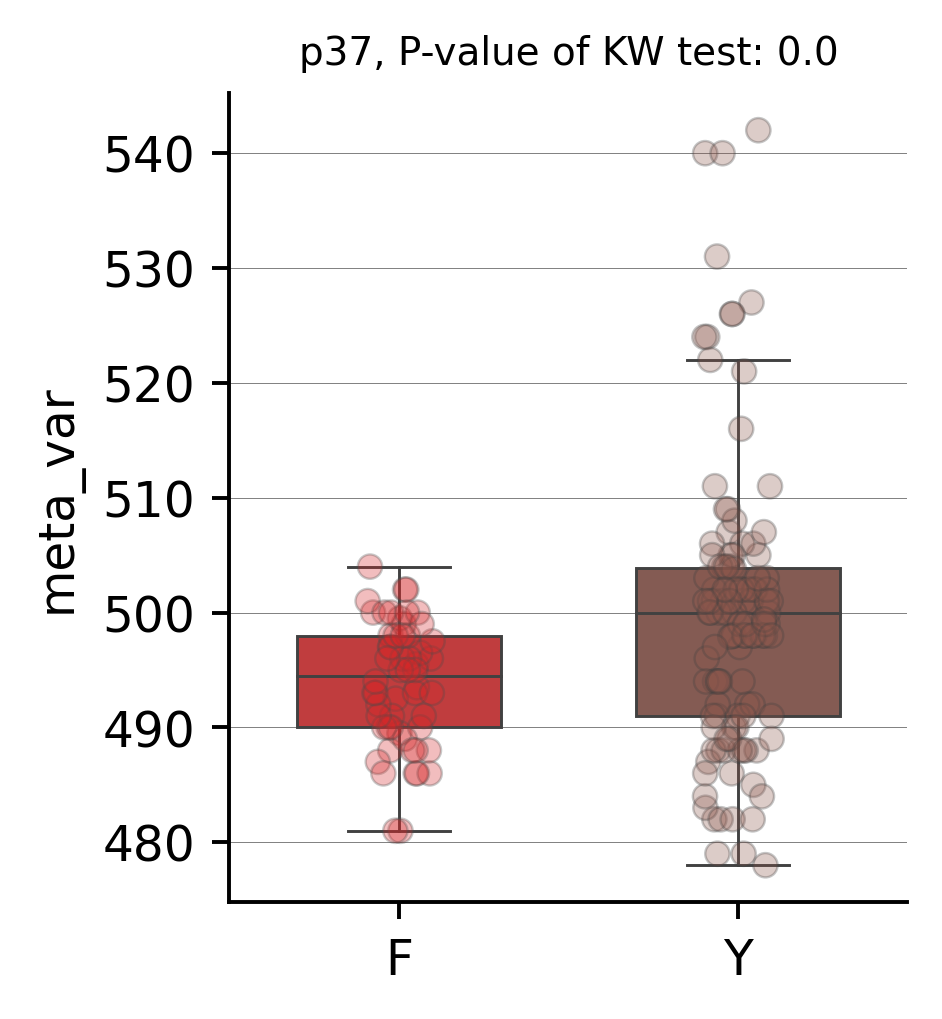

In [24]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(2.5, 3))

In [25]:
from deepBreaks.utils import load_obj
load_rf = load_obj(report_dir + '/rf.pkl')

In [26]:
load_rf

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('rf',
                 RandomForestRegressor(max_features='log2', n_jobs=-1,
                                       random_state=123))])